In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 42, 'n_sample_ratio': 1.0}


1it [00:06,  6.59s/it]

n_sample_ratio=1.0


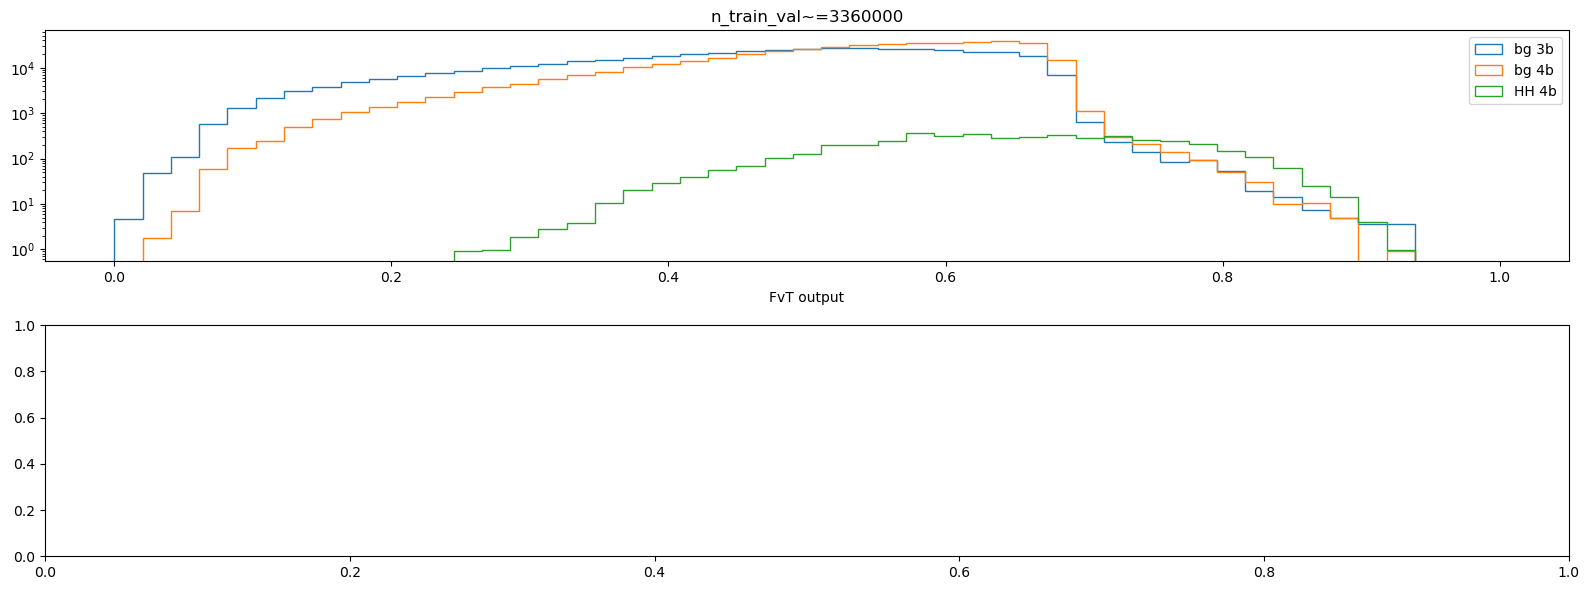

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 52, 'n_sample_ratio': 1.0}


1it [00:06,  6.14s/it]

n_sample_ratio=1.0


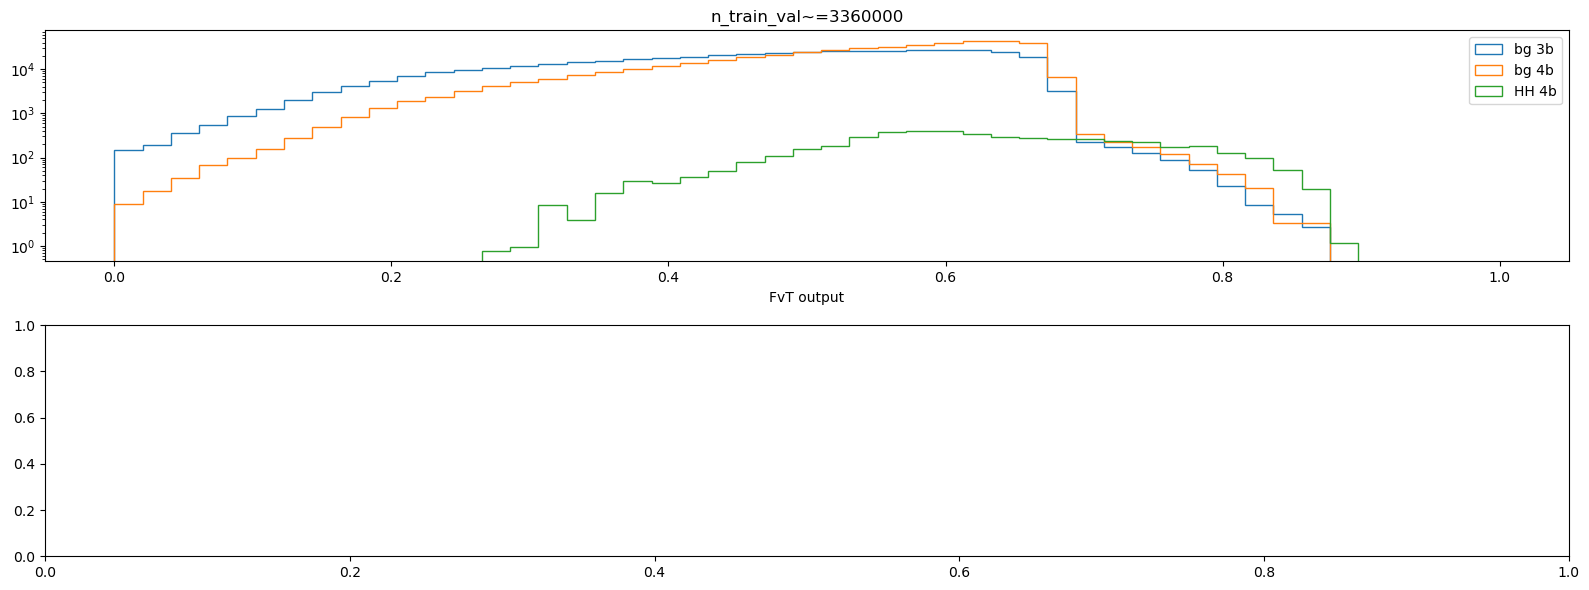

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 62, 'n_sample_ratio': 1.0}


1it [00:06,  6.22s/it]

n_sample_ratio=1.0


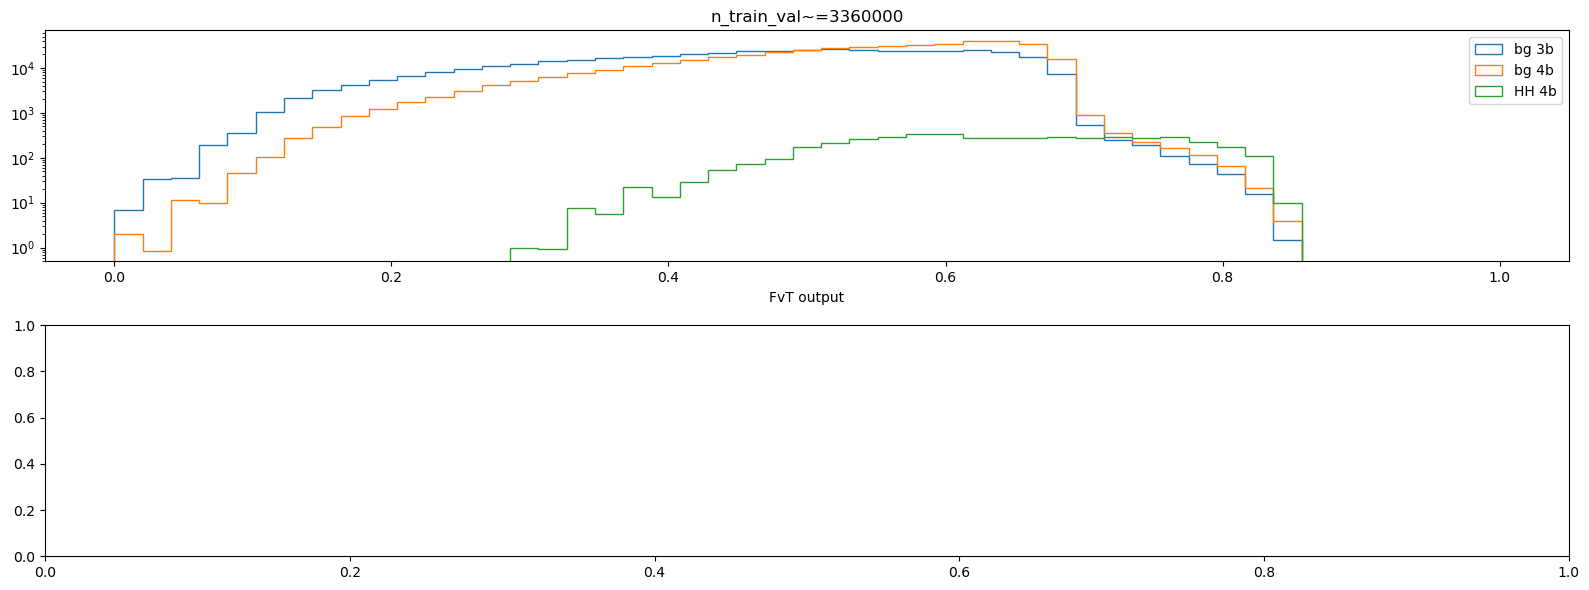

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 72, 'n_sample_ratio': 1.0}


1it [00:06,  6.22s/it]

n_sample_ratio=1.0


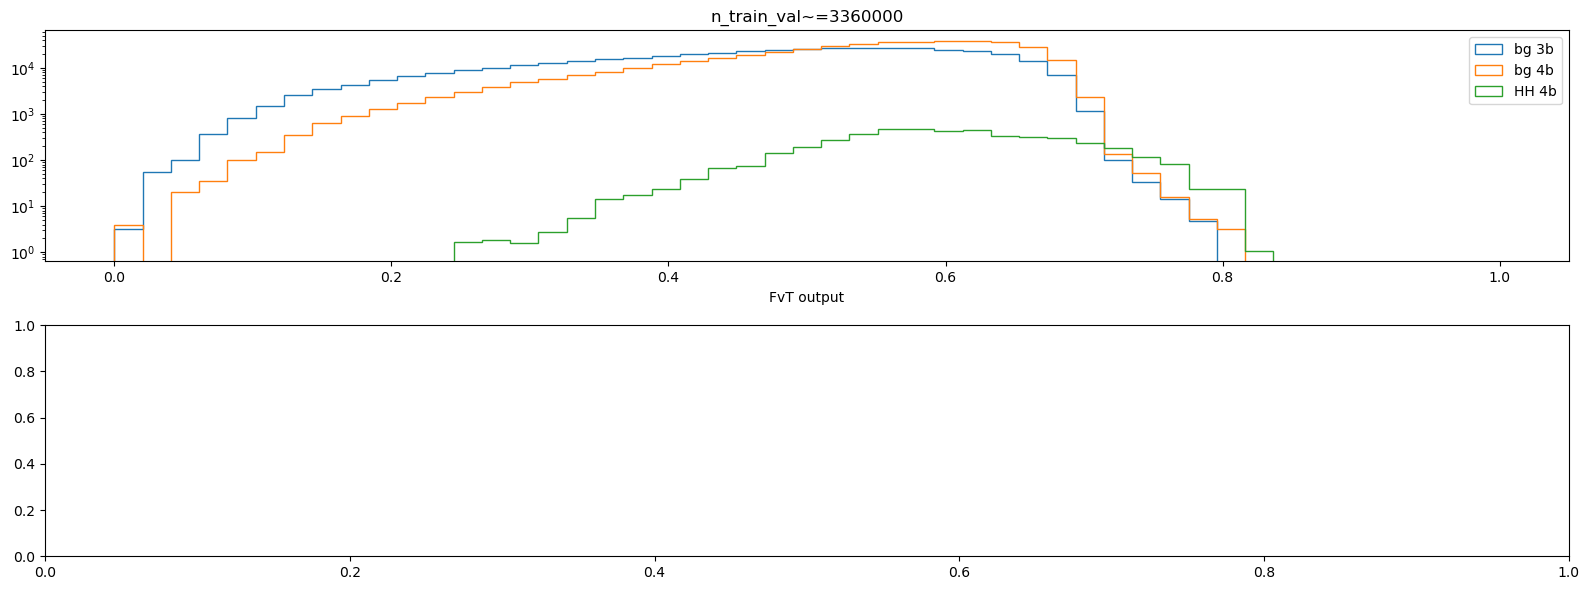

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


1it [00:06,  6.30s/it]

n_sample_ratio=1.0


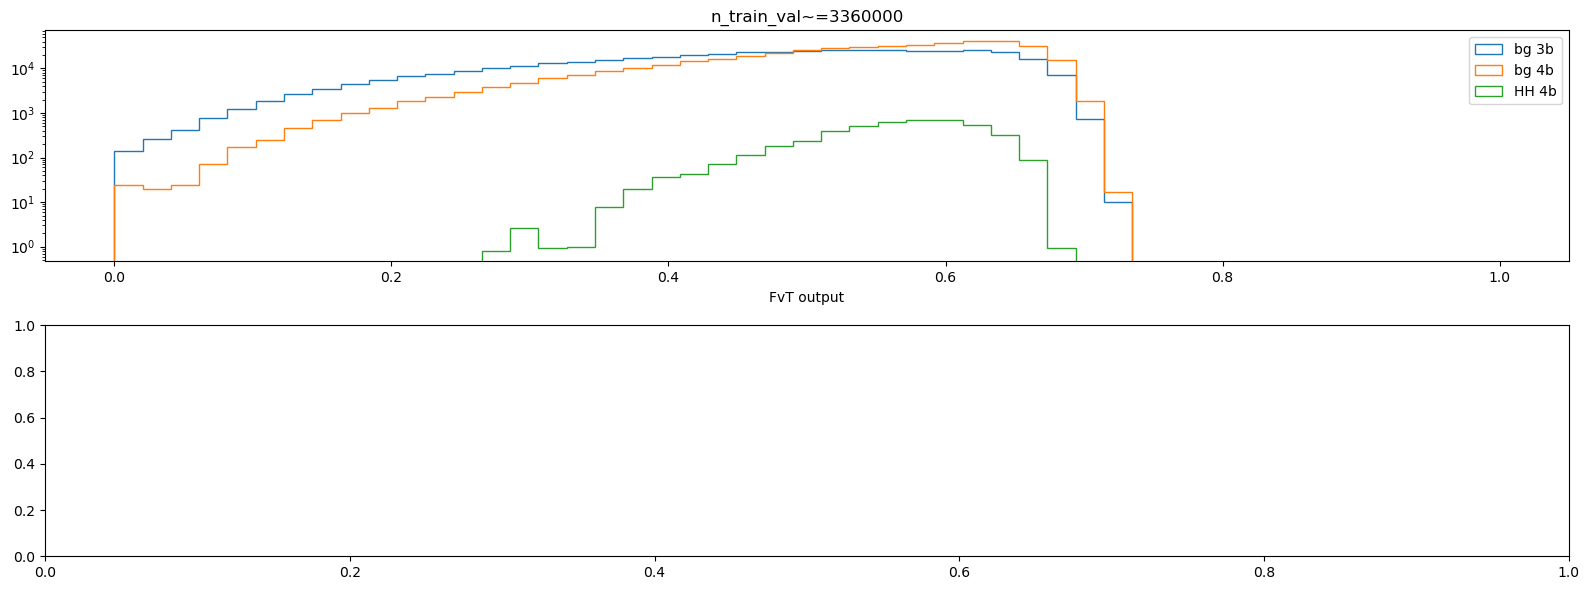

0it [00:00, ?it/s]

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 92, 'n_sample_ratio': 1.0}


1it [00:06,  6.09s/it]

n_sample_ratio=1.0


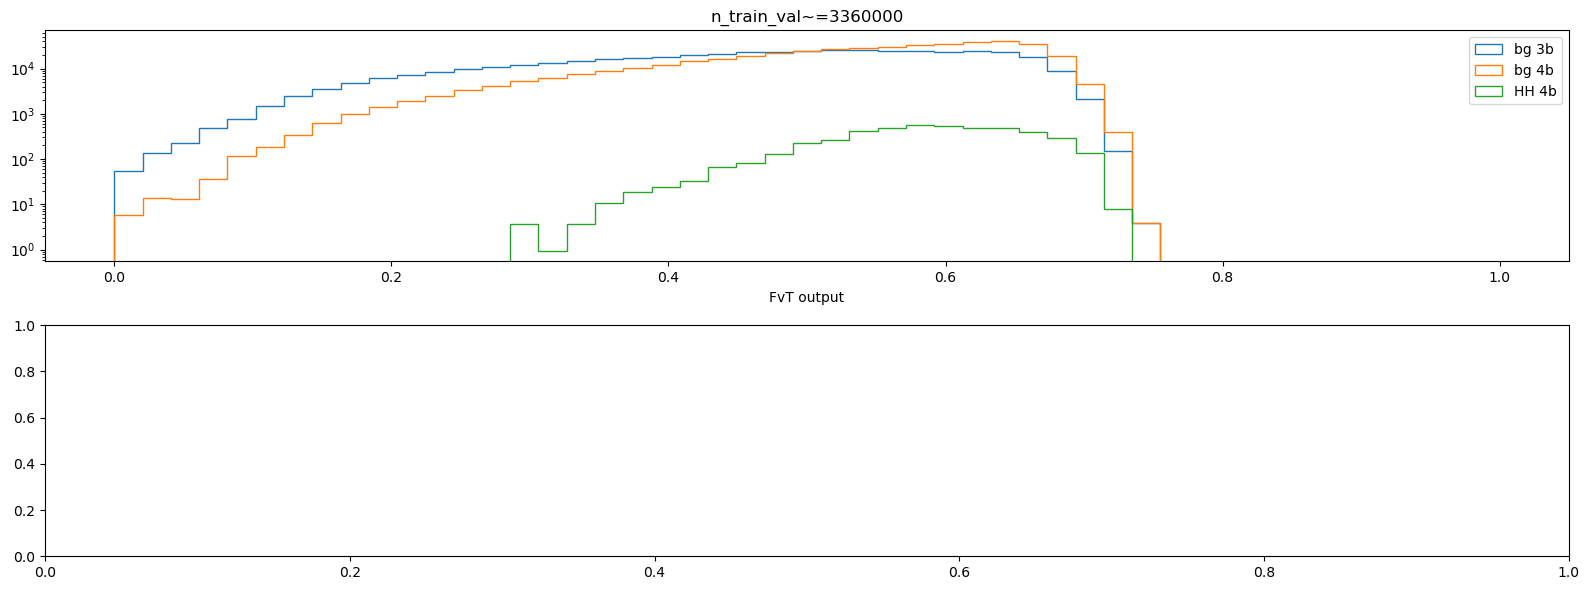

In [3]:
import torch
from dataset import generate_tt_dataset
from training_info import TrainingInfo
import pytorch_lightning as pl
import yaml
from fvt_classifier import FvTClassifier
from code_fragments import att_q_repr_hist, fvt_score_hist
from events_data import EventsData
import tqdm
import numpy as np
import matplotlib.pyplot as plt

config_filename = "configs/fvt_training_n_samples_1.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
n_all4b = config["n_all4b"]
signal_ratio = config["signal_ratio"]
test_ratio = config["test_ratio"]
# n_sample_ratios = config["n_sample_ratios"]
n_sample_ratios = [1.0]
seeds = [42, 52, 62, 72, 82, 92]
w_cuts = np.arange(0.01, 1.01, 0.01)

fvt_scores_dict = {seed: {} for seed in seeds}
att_q_reprs_dict = {seed: {} for seed in seeds}
events_test_dict = {}
fvt_models_dict = {seed: {} for seed in seeds}

for seed in seeds:
    _, dinfo_test = generate_tt_dataset(
            seed,
            n_3b,
            n_all4b,
            signal_ratio,
            test_ratio,
        )
    events_test = EventsData.from_dataframe(dinfo_test.fetch_data(), features)
    events_test_dict[seed] = events_test

    nrows = 2
    ncols = int(np.ceil(len(n_sample_ratios) / 2))
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

    for ax_cnt, n_sample_ratio in tqdm.tqdm(enumerate(n_sample_ratios)):
        hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
        hashes = TrainingInfo.find(hparam_filter)
        assert len(hashes) == 1
        print("successfully loaded", hparam_filter)
        hash = hashes[0]
        tinfo = TrainingInfo.load(hash)
        fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{hash}_best.ckpt")
        fvt_model.eval()

        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax.set_title(f"n_train_val~={1000 * ((len(tinfo.dinfo_train) + len(tinfo.dinfo_val)) // 1000)}")
        device = torch.device("cuda:0")
        fvt_model = fvt_model.to(device)
        events_test.set_model_scores(fvt_model)
        fvt_score_hist(events_test, current_ax, logscale=True)
        
        print(f"n_sample_ratio={n_sample_ratio}")
        # att_q_repr_hist(events_test, title=f"n_sample_ratio={n_sample_ratio}")

        fvt_scores_dict[seed][n_sample_ratio] = events_test.fvt_score
        att_q_reprs_dict[seed][n_sample_ratio] = events_test.att_q_repr
        fvt_models_dict[seed][n_sample_ratio] = fvt_model

    fig.tight_layout()
    fig.show()

    plt.show()
    plt.close()

seed 42


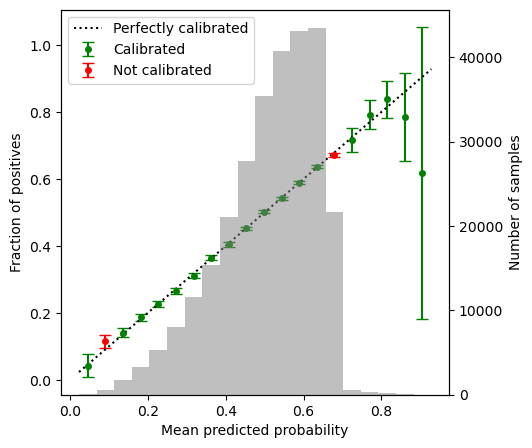

In [4]:
seed = 42
n_sample_ratio = 1.0


print("seed", seed)
events = events_test_dict[seed]
fvt_scores = fvt_scores_dict[seed][n_sample_ratio]
att_q_reprs = att_q_reprs_dict[seed][n_sample_ratio]

idxs = np.arange(len(events)) % 3
idxs = idxs[np.random.permutation(len(idxs))]

events_1 = events[idxs == 0]
events_2 = events[idxs == 1]
events_3 = events[idxs == 2]

X_1 = att_q_reprs[idxs == 0]
X_2 = att_q_reprs[idxs == 1]
X_3 = att_q_reprs[idxs == 2]

y_1 = events_1.is_4b
y_2 = events_2.is_4b
y_3 = events_3.is_4b

is_signal_1 = events_1.is_signal
is_signal_2 = events_2.is_signal
is_signal_3 = events_3.is_signal

from plots import calibration_plot
import torch.nn.functional as F

fvt_model = fvt_models_dict[seed][n_sample_ratio]
fvt_model.eval()

q = torch.tensor(events_3.q_repr, dtype=torch.float32).to(device)
n = len(events_3)
q_score = fvt_model.select_q(q)
q_score = F.softmax(q_score, dim=-1)
event = torch.matmul(q, q_score.transpose(1, 2))
event = event.view(n, fvt_model.dim_q, 1)

# project the final event-level pixel into the class score space
class_score = fvt_model.out(event)
class_score = class_score.view(n, fvt_model.num_classes)
probs4b_est = F.softmax(class_score, dim=-1)[:, 1].detach().cpu().numpy()

calibration_plot(probs4b_est, events_3.is_4b, sample_weights=events_3.weights, bins=20)

In [6]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from network_blocks import GhostBatchNorm1d, conv1d
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import EarlyStopping

class MLPClassifierTorch(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, learning_rate=0.001, random_state=42):
        super().__init__()
        self.save_hyperparameters()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.random_state = random_state

        torch.manual_seed(random_state)
        np.random.seed(random_state)

        # # Define the network layers
        # self.layers = nn.Sequential(
        #     conv1d(input_size, hidden_size, kernel_size=1, batchNorm=True),
        #     nn.SiLU(),
        #     conv1d(hidden_size, hidden_size, kernel_size=1, batchNorm=True),
        #     nn.SiLU(),
        #     conv1d(hidden_size, num_classes, kernel_size=1, batchNorm=False),
        # )

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
        self.val_losses = []
        self.val_weights = []

    def forward(self, x):
        # Forward pass
        # if x.dim() == 2:
        #     x = x.unsqueeze(2)
        # x = self.layers(x)
        # return x.squeeze(2)

        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y, reduce="none") * w)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y, reduce="none") * w)
        self.log('val_loss', loss)
        self.val_losses.append(loss)
        self.val_weights.append(w.sum())
        return loss
    
    def on_validation_epoch_end(self):
        val_losses = torch.tensor(self.val_losses)
        val_weights = torch.tensor(self.val_weights)
        avg_loss = torch.sum(val_losses) / torch.sum(val_weights)
        self.log('avg_val_loss', avg_loss, prog_bar=True)
        
        self.val_losses = []
        self.val_weights = []
    
    def test_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y, reduce="none") * w)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def predict_proba(self, x):
        self.eval()
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        logits = self(x)
        return torch.softmax(logits, dim=1).detach().cpu().numpy()
    
    def fit(self, X, y, w):
        self.train()
        X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X, y, w, test_size=0.2, random_state=self.hparams.random_state)
        
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.long)
        w_train = torch.tensor(w_train, dtype=torch.float32)

        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)
        w_val = torch.tensor(w_val, dtype=torch.float32)

        train_dataset = TensorDataset(X_train, y_train, w_train)
        val_dataset = TensorDataset(X_val, y_val, w_val)

        train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=2**8, shuffle=False, num_workers=4)

        early_stop_callback = EarlyStopping(monitor='avg_val_loss', min_delta=1e-4, patience=5, verbose=False, mode='min')
        trainer = pl.Trainer(max_epochs=1, callbacks=[early_stop_callback], 
                             logger=False,                   # Disable all logging
                    enable_progress_bar=False,      # Disable the progress bar
                    enable_model_summary=False,     # Disable the model summary
                    enable_checkpointing=False)
                             
        trainer.fit(self, train_loader, val_loader)

In [90]:
from plots import calibration_plot

class AttentionClassifierTorch(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, learning_rate=1e-4, random_state=42, 
                 fvt_hash=None):
        super().__init__()
        self.save_hyperparameters()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.random_state = random_state

        torch.manual_seed(random_state)
        np.random.seed(random_state)

        # self.select_q = nn.Sequential(
        #     conv1d(
        #         input_size, hidden_size, 1, name="quadjet selector", batchNorm=True
        #     ),
        #     nn.SiLU(),
        #     conv1d(
        #         hidden_size, 1, 1, name="quadjet selector", batchNorm=False
        #     ),
        # )

        if fvt_hash is not None:
            fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{fvt_hash}_best.ckpt")
            fvt_model.eval()
            self.select_q = fvt_model.select_q
            self.out = fvt_model.out
        else:
            self.select_q = conv1d(input_size, 1, 1, name="quadjet selector", batchNorm=True)
            self.out = conv1d(
                input_size, num_classes, 1, name="out", batchNorm=True
            )

        self.val_losses = []
        self.val_weights = []

    def forward(self, q):
        n = q.shape[0]
        q_score = self.select_q(q)
        q_score = F.softmax(q_score, dim=-1)
        event = torch.matmul(q, q_score.transpose(1, 2))
        event = event.view(n, self.input_size, 1)

        # project the final event-level pixel into the class score space
        class_score = self.out(event)
        class_score = class_score.view(n, self.num_classes)

        return class_score

    def training_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y) * w)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y) * w)
        self.log('val_loss', loss)
        self.val_losses.append(loss)
        self.val_weights.append(w.sum())
        return loss
    
    
    def on_validation_epoch_end(self):
        val_losses = torch.tensor(self.val_losses)
        val_weights = torch.tensor(self.val_weights)
        avg_loss = torch.sum(val_losses) / torch.sum(val_weights)
        self.log('avg_val_loss', avg_loss, prog_bar=True)

        # print()
        # print("avg_val_loss", avg_loss.item(), "at epoch", self.current_epoch)

        # self.eval()
        # q = torch.tensor(events_3.q_repr, dtype=torch.float32).to(device)
        # n = len(events_3)
        # q_score = self.select_q(q)
        # q_score = F.softmax(q_score, dim=-1)
        # event = torch.matmul(q, q_score.transpose(1, 2))
        # event = event.view(n, self.input_size, 1)

        # # project the final event-level pixel into the class score space
        # class_score = self.out(event)
        # class_score = class_score.view(n, self.num_classes)
        # probs4b_est = F.softmax(class_score, dim=-1)[:, 1].detach().cpu().numpy()

        # calibration_plot(probs4b_est, events_3.is_4b, sample_weights=events_3.weights, bins=20)

        # # calculate test loss

        # loss_ev3 = torch.sum(F.cross_entropy(class_score, torch.tensor(events_3.is_4b, dtype=torch.long).to(self.device))
        #                      * torch.tensor(events_3.weights, dtype=torch.float32).to(self.device))
        # loss_ev3 = loss_ev3 / torch.sum(torch.tensor(events_3.weights, dtype=torch.float32).to(self.device))
        # print("events_3_loss", loss_ev3.item())

        self.val_losses = []
        self.val_weights = []
    
        self.train()
        
    def test_step(self, batch, batch_idx):
        x, y, w = batch
        logits = self(x)
        loss = torch.sum(F.cross_entropy(logits, y) * w)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def predict_proba(self, x):
        self.eval()
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        logits = self(x)
        return torch.softmax(logits, dim=1).detach().cpu().numpy()
    
    def fit(self, X, y, w):
        self.train()
        X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X, y, w, test_size=1/3, random_state=self.hparams.random_state)

        # fit batch size to the number of samples
        batch_size = 2**10

        X_train = X_train[:len(X_train) // batch_size * batch_size]
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = y_train[:len(y_train) // batch_size * batch_size]
        y_train = torch.tensor(y_train, dtype=torch.long)
        w_train = w_train[:len(w_train) // batch_size * batch_size]
        w_train = torch.tensor(w_train, dtype=torch.float32)

        X_val = X_val[:len(X_val) // batch_size * batch_size]
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = y_val[:len(y_val) // batch_size * batch_size]
        y_val = torch.tensor(y_val, dtype=torch.long)
        w_val = w_val[:len(w_val) // batch_size * batch_size]
        w_val = torch.tensor(w_val, dtype=torch.float32)
    

        train_dataset = TensorDataset(X_train, y_train, w_train)
        val_dataset = TensorDataset(X_val, y_val, w_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        early_stop_callback = EarlyStopping(monitor='avg_val_loss', min_delta=0.0, patience=5, mode='min')
        trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback], 
                             logger=False,                   # Disable all logging 
                             )
                    # enable_progress_bar=False,      # Disable the progress bar
                    # enable_model_summary=False,     # Disable the model summary
                    # enable_checkpointing=False)
                             
        trainer.fit(self, train_loader, val_loader)

# Calibration vs Loss

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | select_q | conv1d | 8     
1 | out      | conv1d | 16    
------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}
Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 90.04it/s] 
avg_val_loss 0.6630967259407043 at epoch 0
events_3_loss 0.6682653427124023
Epoch 0: 100%|██████████| 182/182 [00:01<00:00, 177.81it/s]                
avg_val_loss 0.6659458875656128 at epoch 0
events_3_loss 0.6669808626174927
Epoch 1: 100%|██████████| 182/182 [00:01<00:00, 156.55it/s, avg_val_loss=0.666]
avg_val_loss 0.6659442782402039 at epoch 1
events_3_loss 0.6668843030929565
Epoch 2: 100%|██████████| 182/182 [00:01<00:00, 156.54it/s, avg_val_loss=0.666]
avg_val_loss 0.6659342050552368 at epoch 2
events_3_loss 0.6669231057167053
Epoch 3: 100%|██████████| 182/182 [00:01<00:00, 158.70it/s, avg_val_loss=0.666]
avg_val_loss 0.6659419536590576 at epoch 3
events_3_loss 0.6669934391975403
Epoch 4: 100%|██████████| 182/182 [00:01<00:00, 156.34it/s, avg_val_loss=0.666]
avg_val_loss 0.6658579707145691 at epoch 4
e

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 182/182 [00:02<00:00, 88.64it/s, avg_val_loss=0.666]


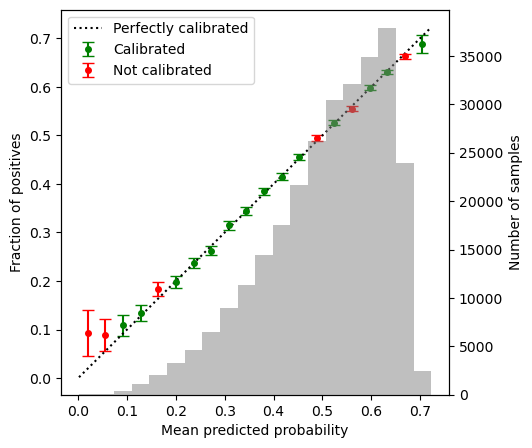

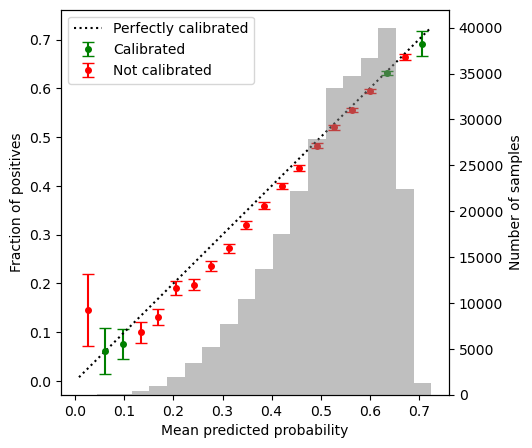

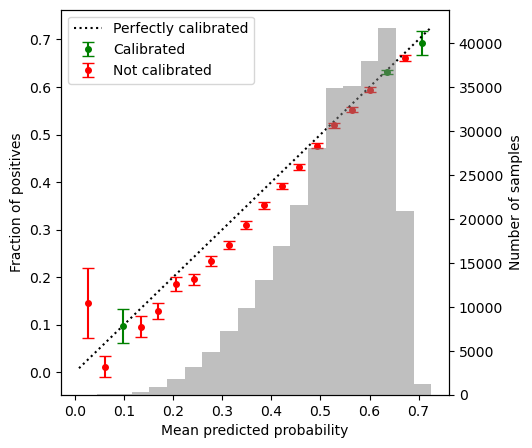

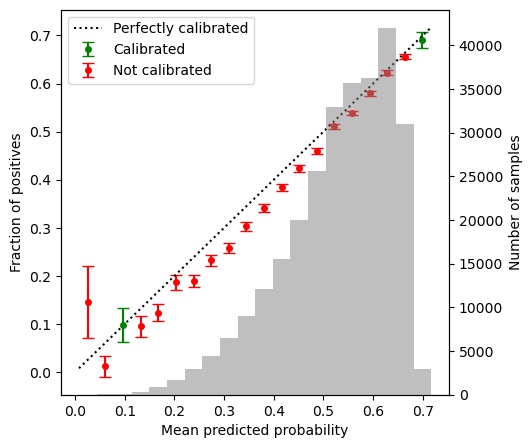

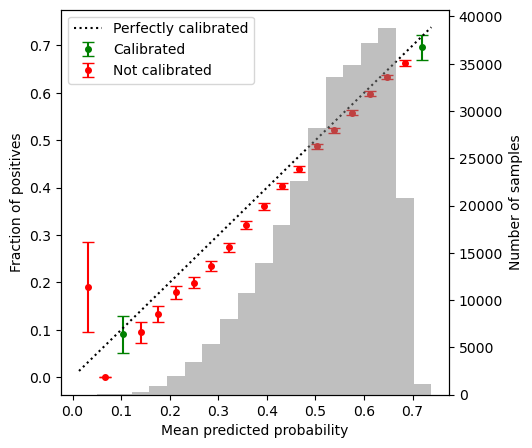

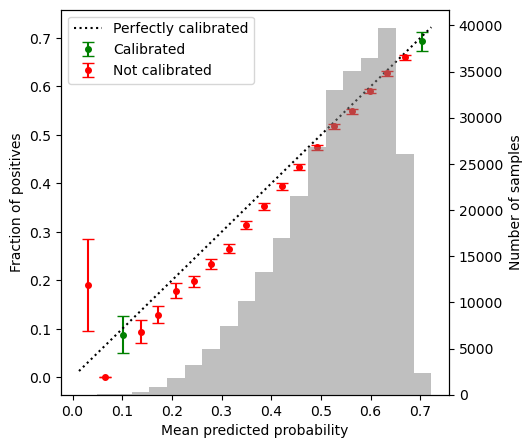

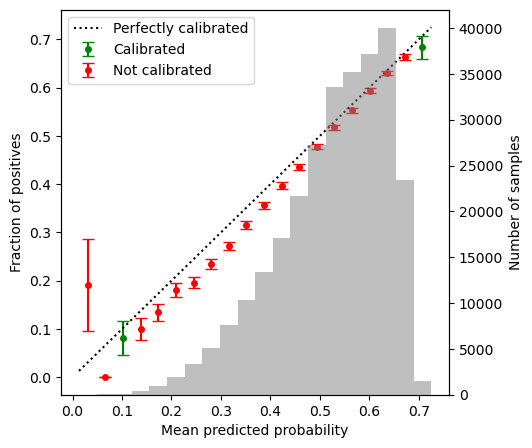

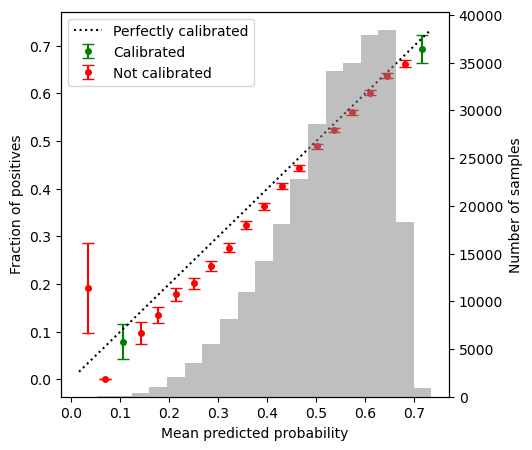

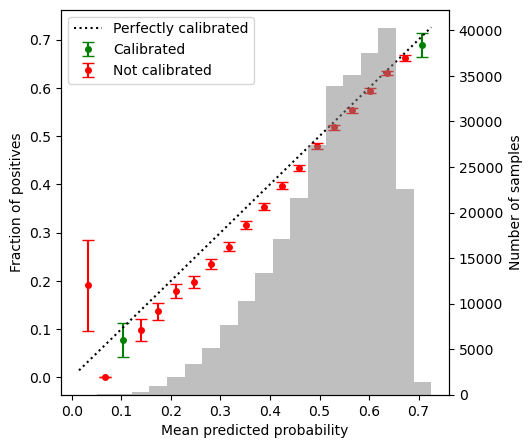

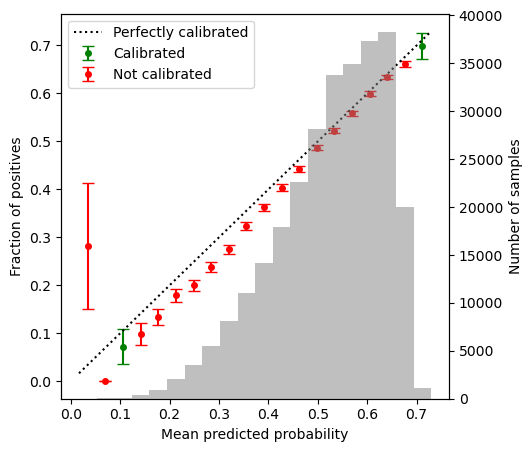

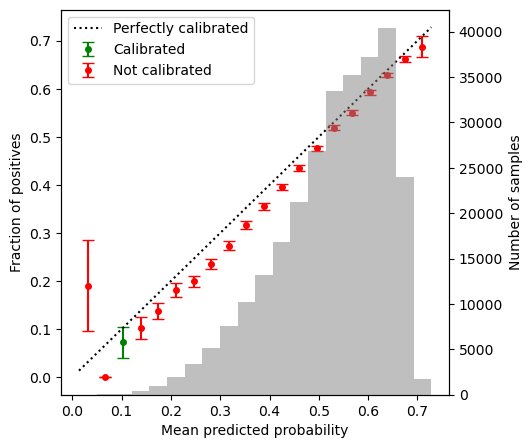

In [67]:
seed = 82
n_sample_ratio = 1.0
noise_scale = 0.1

np.random.seed(seed)
torch.manual_seed(seed)

events = events_test_dict[seed]
q_reprs = events.q_repr

fvt_model = fvt_models_dict[seed][n_sample_ratio]
fvt_model.eval()

# dinfo_train, _ = generate_tt_dataset(
#     seed,
#     n_3b,
#     n_all4b,
#     signal_ratio,
#     1 - test_ratio,
# )
# events_train = EventsData.from_dataframe(dinfo_train.fetch_data(), features)
# events_train.set_model_scores(fvt_models_dict[seed][n_sample_ratio])

idxs = np.arange(len(events)) % 3
idxs = idxs[np.random.permutation(len(idxs))]

events_1 = events[idxs == 0]
events_2 = events[idxs == 1]
events_3 = events[idxs == 2]

# events_3_dict[seed] = events_3.clone()

X_1 = q_reprs[idxs == 0]
X_2 = q_reprs[idxs == 1]
X_3 = q_reprs[idxs == 2]

# smear X_2
X_2 = X_2 + noise_scale * np.random.randn(*X_2.shape) * (np.max(X_2, axis=0) - np.min(X_2, axis=0))

y_1 = events_1.is_4b
y_2 = events_2.is_4b
y_3 = events_3.is_4b

is_signal_1 = events_1.is_signal
is_signal_2 = events_2.is_signal
is_signal_3 = events_3.is_signal

hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
hashes = TrainingInfo.find(hparam_filter)
assert len(hashes) == 1
print("successfully loaded", hparam_filter)
hash = hashes[0]

clf1 = AttentionClassifierTorch(input_size=6, hidden_size=6, 
                                num_classes=2, random_state=seed, 
                                fvt_hash=hash, learning_rate=1e-3)
clf1.to(device)
clf1.fit(X_1, y_1, events_1.weights)
# clf1.fit(torch.tensor(events_train.q_repr, dtype=torch.float32), 
#          events_train.is_4b_torch, 
#          events_train.weights_torch)

loss 0.6668697595596313
loss 0.6682653427124023


/tmp/ipykernel_1661513/8613876.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_ev3 = torch.sum(F.cross_entropy(torch.tensor(clf1(torch.tensor(X_3, dtype=torch.float32)), dtype=torch.float32),
/tmp/ipykernel_1661513/8613876.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.sum(F.cross_entropy(torch.tensor(class_score.detach().cpu(), dtype=torch.float32),


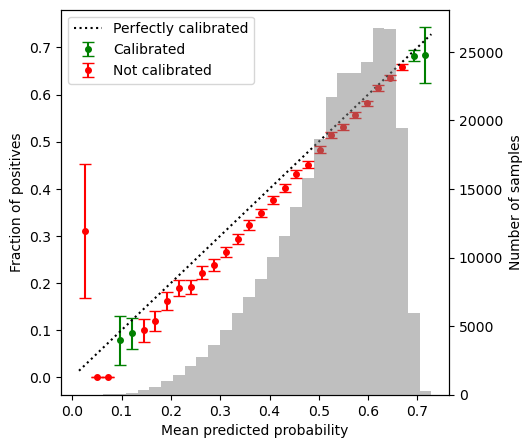

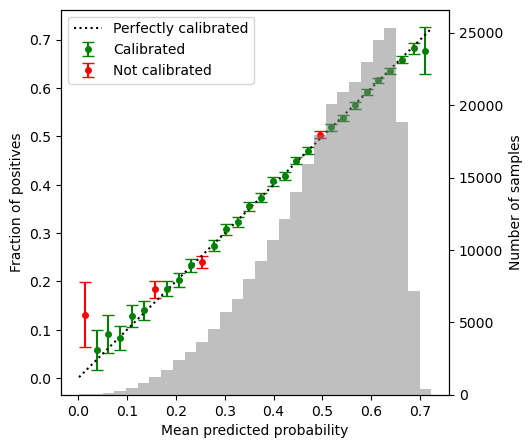

In [88]:
from plots import calibration_plot

clf1.eval()

clf1 = clf1.to("cpu")
prob1 = clf1.predict_proba(X_3)
calibration_plot(prob1[:, 1], y_3, sample_weights=events_3.weights, bins=30)

loss_ev3 = torch.sum(F.cross_entropy(torch.tensor(clf1(torch.tensor(X_3, dtype=torch.float32)), dtype=torch.float32), 
                                     torch.tensor(y_3, dtype=torch.long)) * events_3.weights_torch)
loss_ev3 = loss_ev3 / torch.sum(events_3.weights_torch)
print("loss", loss_ev3.item())

device = fvt_model.device
fvt_model = fvt_model.to(device)
q = torch.tensor(events_3.q_repr, dtype=torch.float32).to(device)
n = len(events_3)
q_score = fvt_model.select_q(q.to(device))
q_score = F.softmax(q_score, dim=-1)
event = torch.matmul(q, q_score.transpose(1, 2))
event = event.view(n, fvt_model.dim_q, 1)
fvt_model.eval()

# project the final event-level pixel into the class score space
class_score = fvt_model.out(event)
class_score = class_score.view(n, fvt_model.num_classes)
probs4b_est = F.softmax(class_score, dim=-1)[:, 1].detach().cpu().numpy()

calibration_plot(probs4b_est, y_3, sample_weights=events_3.weights, bins=30)

# calculate loss
loss = torch.sum(F.cross_entropy(torch.tensor(class_score.detach().cpu(), dtype=torch.float32),
                                 events_3.is_4b_torch) * events_3.weights_torch)
loss = loss / torch.sum(events_3.weights_torch)
loss = loss.item()
print("loss", loss)

successfully loaded {'experiment_name': 'fvt_training_n_samples_1', 'seed': 82, 'n_sample_ratio': 1.0}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type   | Params
------------------------------------
0 | select_q | conv1d | 8     
1 | out      | conv1d | 16    
------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 83.73it/s] 
avg_val_loss 0.6968565583229065 at epoch 0
events_3_loss 0.6682653427124023
Epoch 0: 100%|██████████| 182/182 [00:01<00:00, 180.95it/s]                
avg_val_loss 0.6734423041343689 at epoch 0
events_3_loss 0.6690546274185181
Epoch 1: 100%|██████████| 182/182 [00:01<00:00, 162.03it/s, avg_val_loss=0.673]
avg_val_loss 0.6730638146400452 at epoch 1
events_3_loss 0.6689905524253845
Epoch 2: 100%|██████████| 182/182 [00:01<00:00, 160.09it/s, avg_val_loss=0.673]
avg_val_loss 0.6730353236198425 at epoch 2
events_3_loss 0.669140636920929
Epoch 3: 100%|██████████| 182/182 [00:01<00:00, 114.41it/s, avg_val_loss=0.673]
avg_val_loss 0.6730420589447021 at epoch 3
events_3_loss 0.6690884828567505
Epoch 4: 100%|██████████| 182/182 [00:01<00:00, 108.10it/s, avg_val_loss=0.673]
avg_val_loss 0.6729558706283569 at epoch 4
events_3_loss 0.6689571142196655
Epoch 5: 100%|██████████| 182/182 [00:01<00:00, 115.61it/s, avg_val_loss

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 182/182 [00:03<00:00, 60.24it/s, avg_val_loss=0.673]


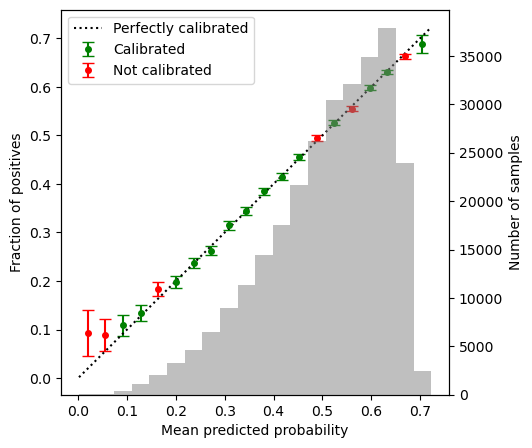

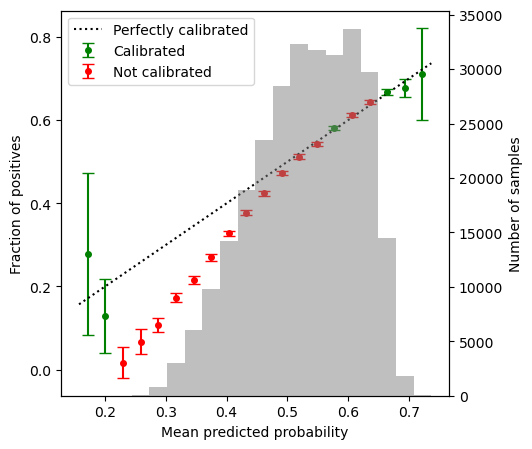

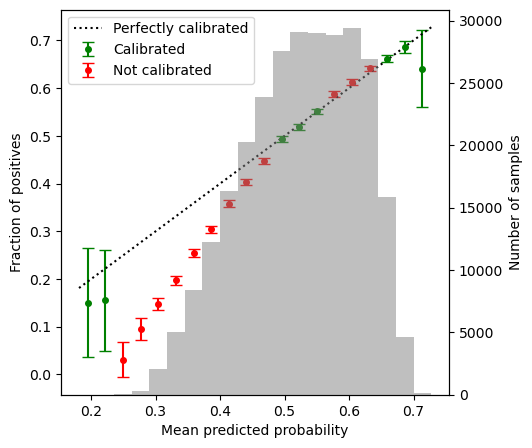

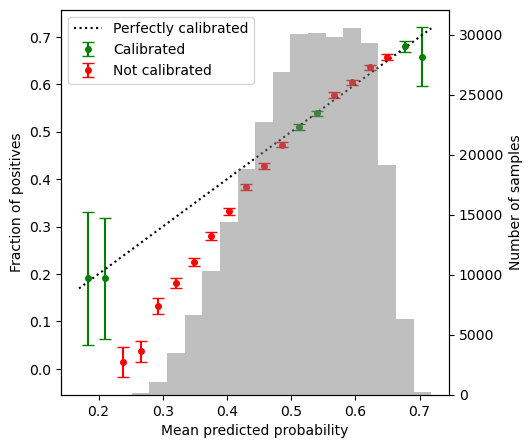

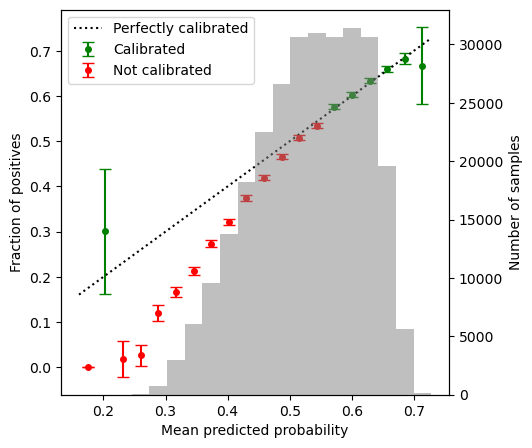

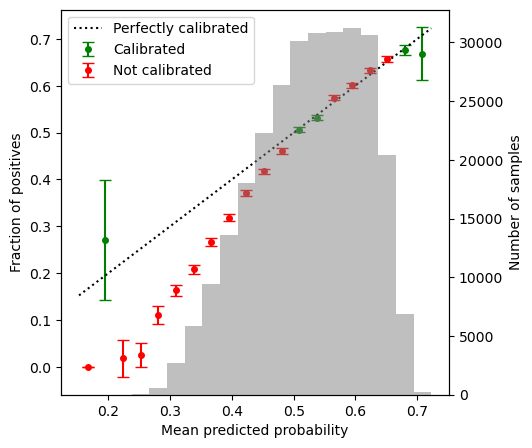

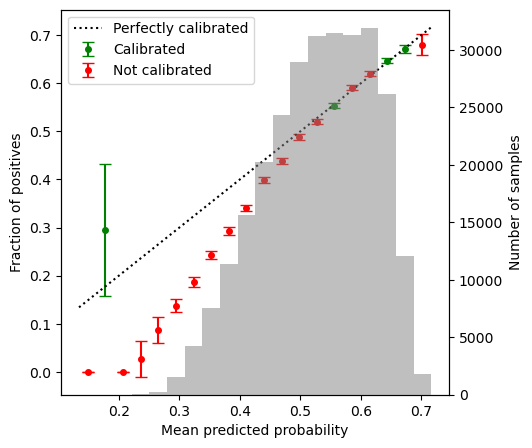

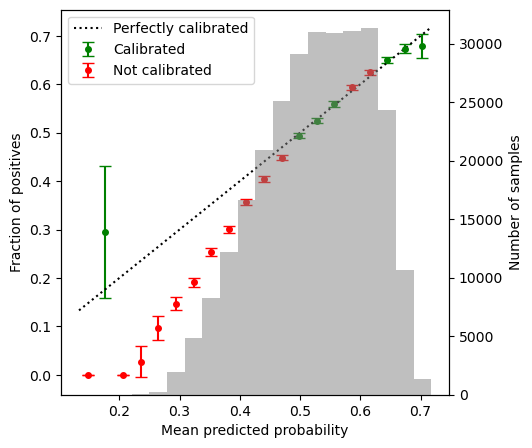

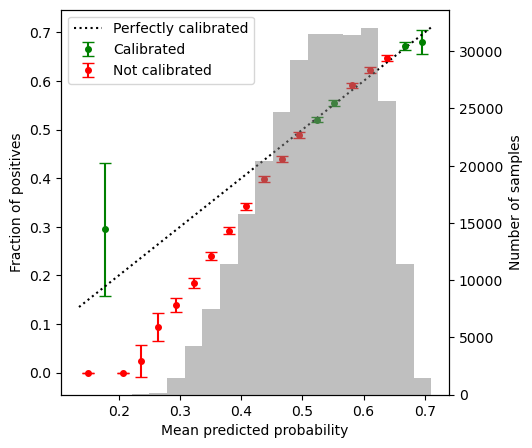

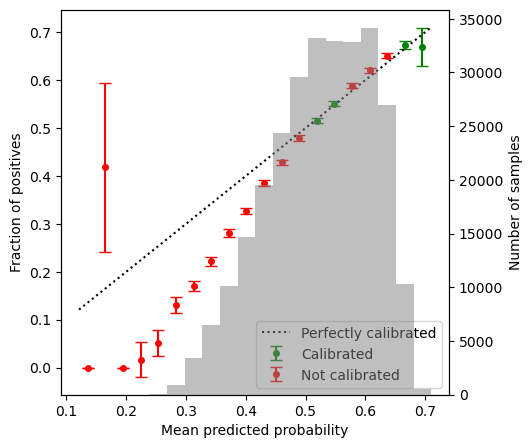

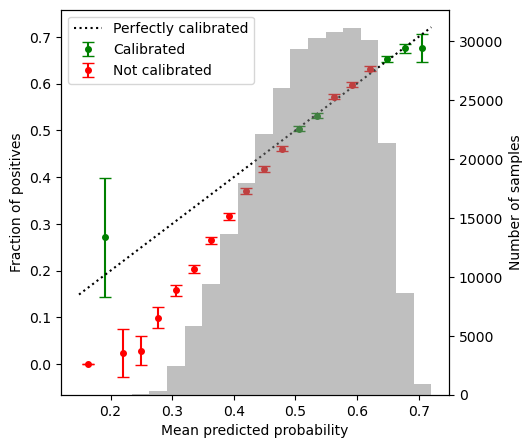

In [89]:
seed = 82
n_sample_ratio = 1.0
noise_scale = 0.1

np.random.seed(seed)
torch.manual_seed(seed)

events = events_test_dict[seed]
q_reprs = events.q_repr

fvt_model = fvt_models_dict[seed][n_sample_ratio]
fvt_model.eval()

idxs = np.arange(len(events)) % 3
idxs = idxs[np.random.permutation(len(idxs))]

events_1 = events[idxs == 0]
events_2 = events[idxs == 1]
events_3 = events[idxs == 2]

# events_3_dict[seed] = events_3.clone()

X_1 = q_reprs[idxs == 0]
X_2 = q_reprs[idxs == 1]
X_3 = q_reprs[idxs == 2]

# smear X_2
X_2 = X_2 + noise_scale * np.random.randn(*X_2.shape) * (np.max(X_2, axis=0) - np.min(X_2, axis=0))

y_1 = events_1.is_4b
y_2 = events_2.is_4b
y_3 = events_3.is_4b

is_signal_1 = events_1.is_signal
is_signal_2 = events_2.is_signal
is_signal_3 = events_3.is_signal

hparam_filter = {"experiment_name": experiment_name, 
                         "seed": seed, 
                         "n_sample_ratio": n_sample_ratio}
hashes = TrainingInfo.find(hparam_filter)
assert len(hashes) == 1
print("successfully loaded", hparam_filter)
hash = hashes[0]

clf2 = AttentionClassifierTorch(input_size=6, hidden_size=6, 
                                num_classes=2, random_state=seed, 
                                fvt_hash=hash, learning_rate=1e-3)
clf2.to(device)
clf2.fit(X_2, y_2, events_2.weights)

seed 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: Fa

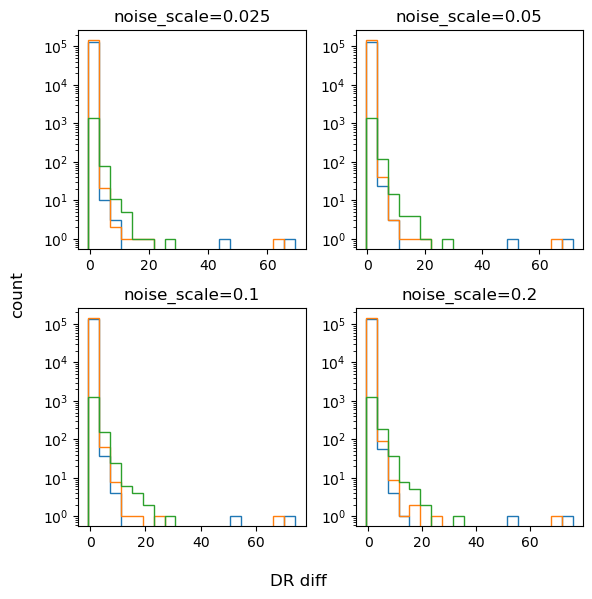

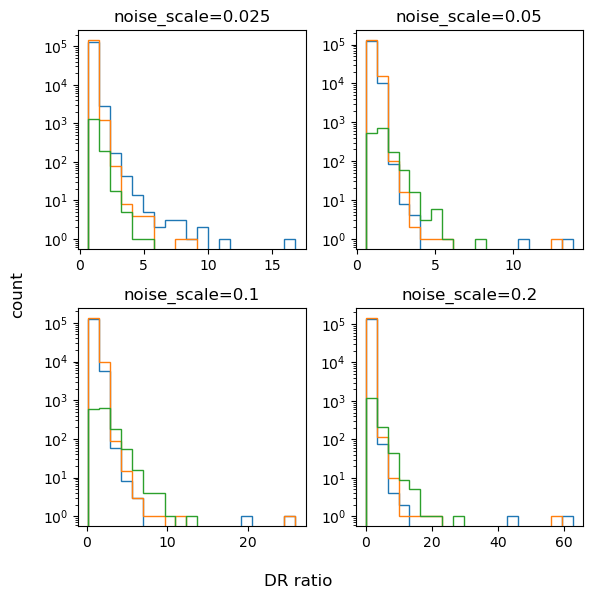

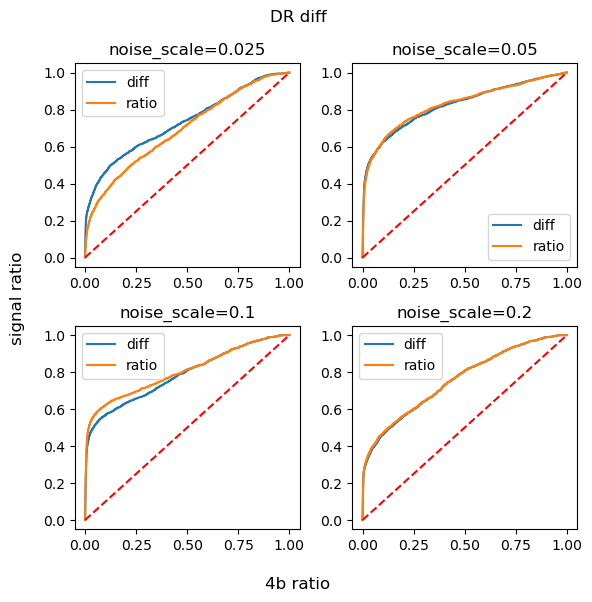

seed 52


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


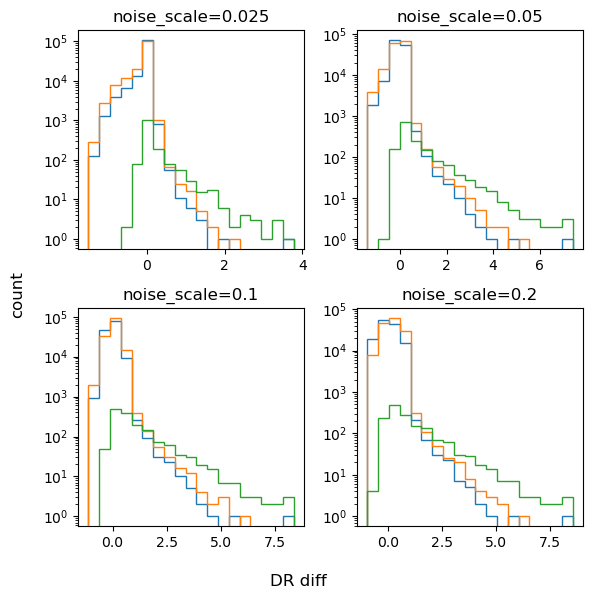

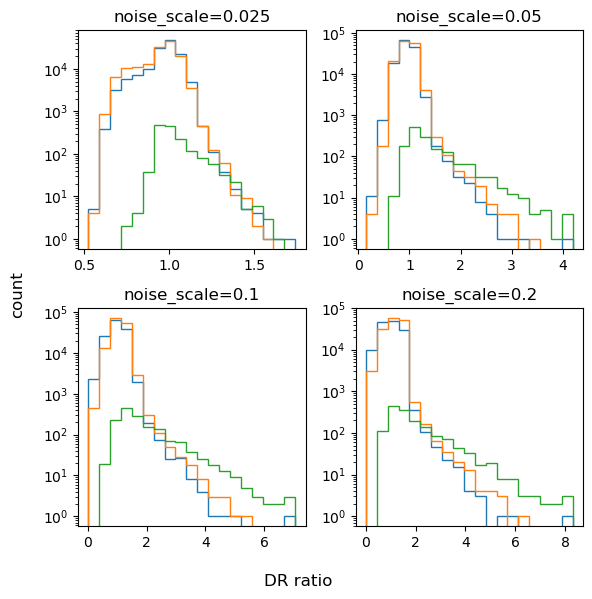

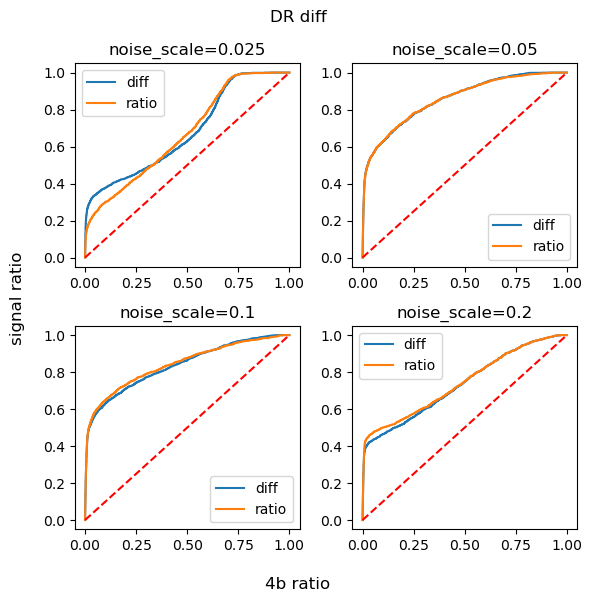

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


seed 62


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


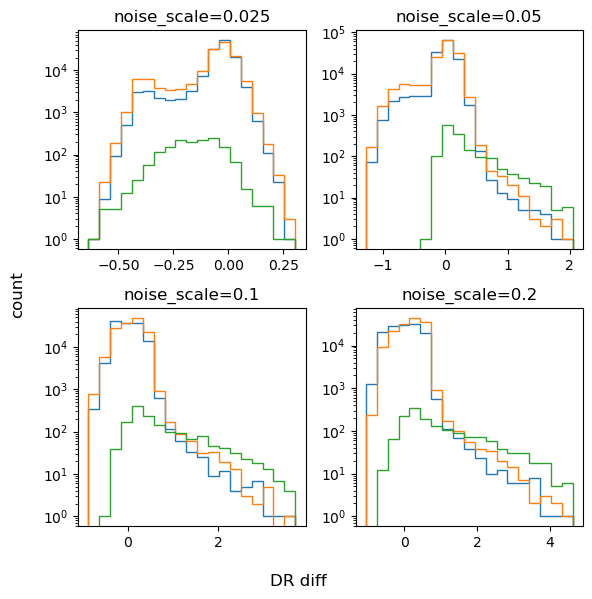

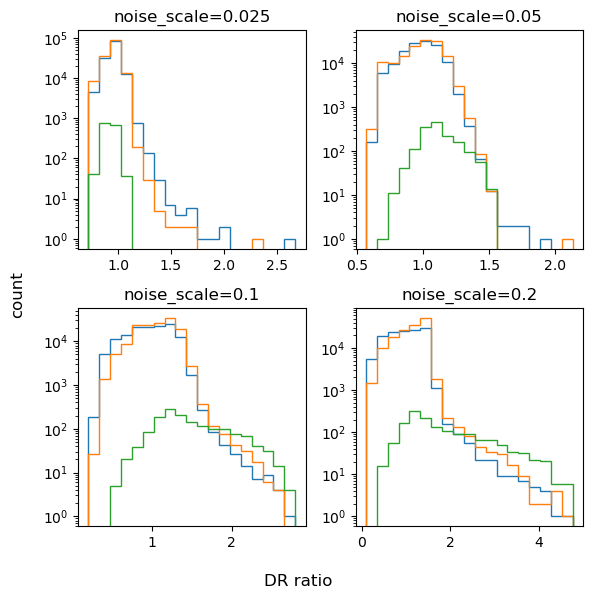

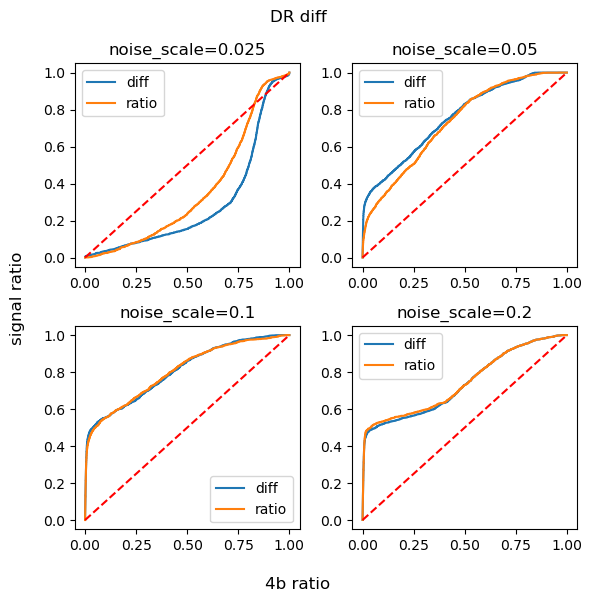

seed 72


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


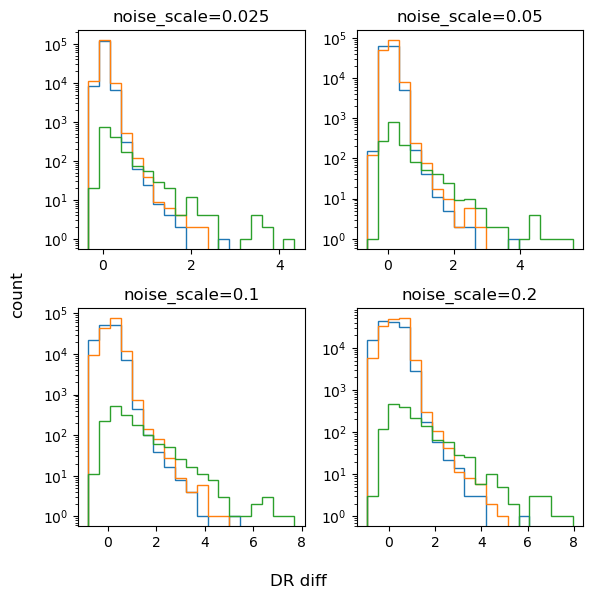

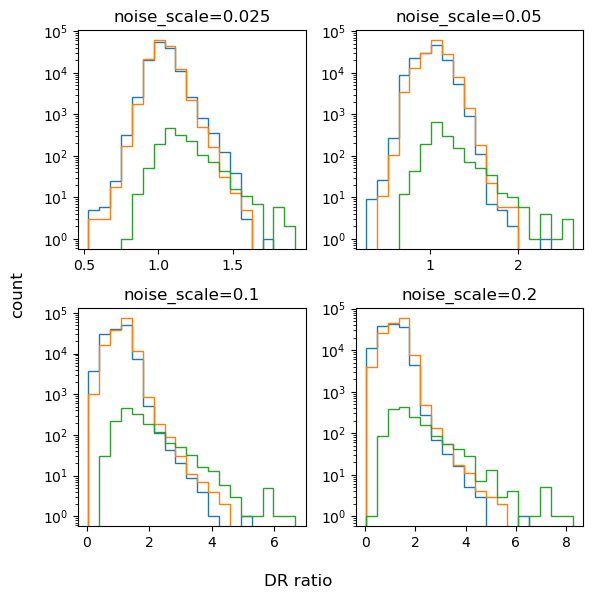

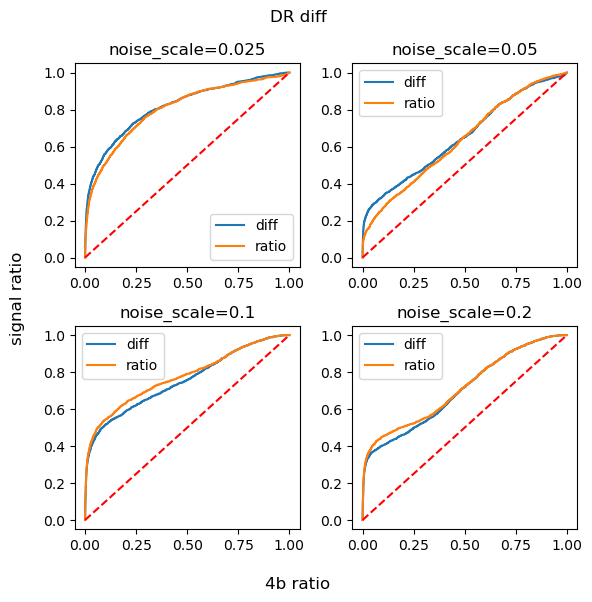

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


seed 82


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


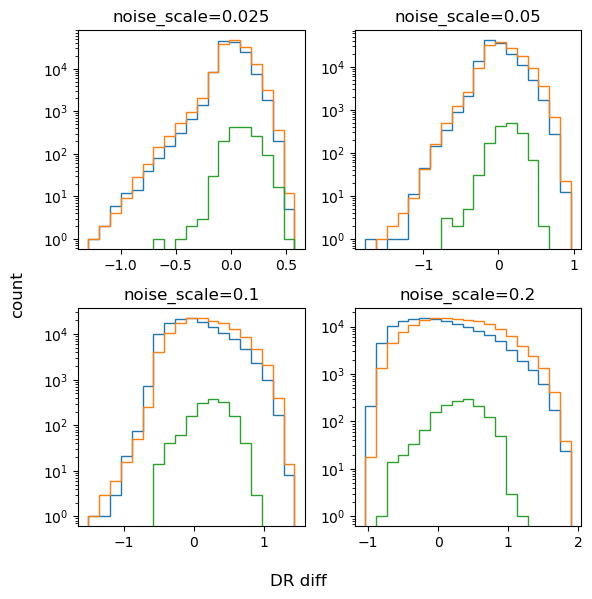

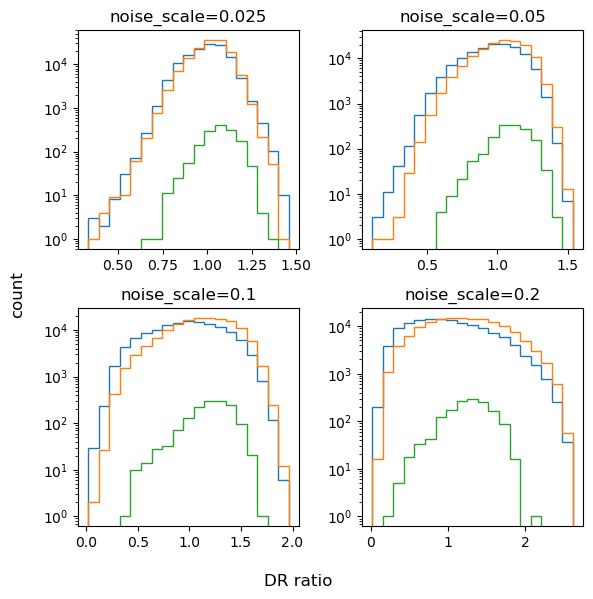

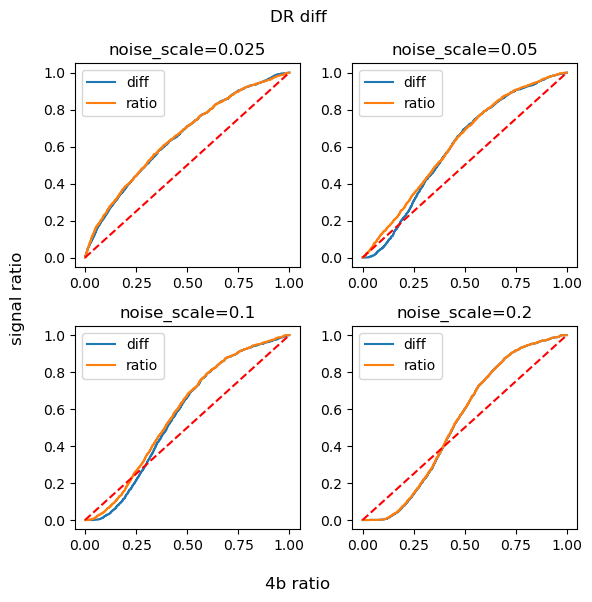

seed 92


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


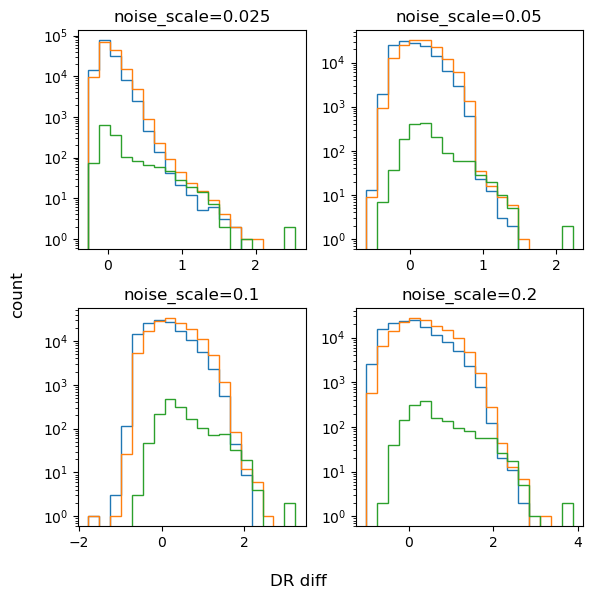

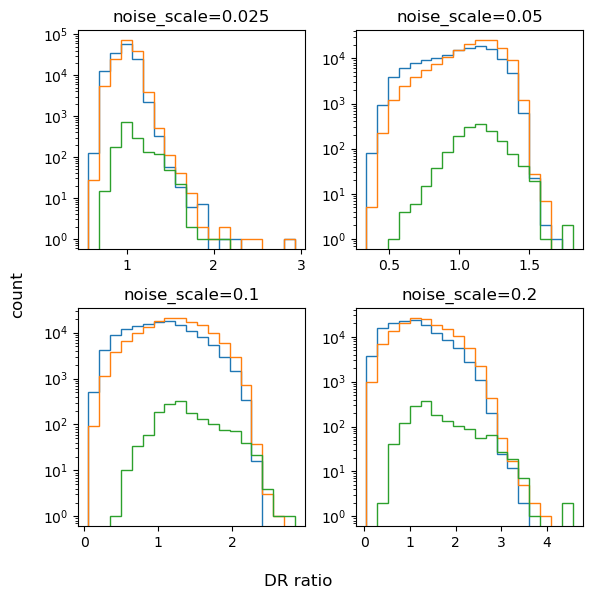

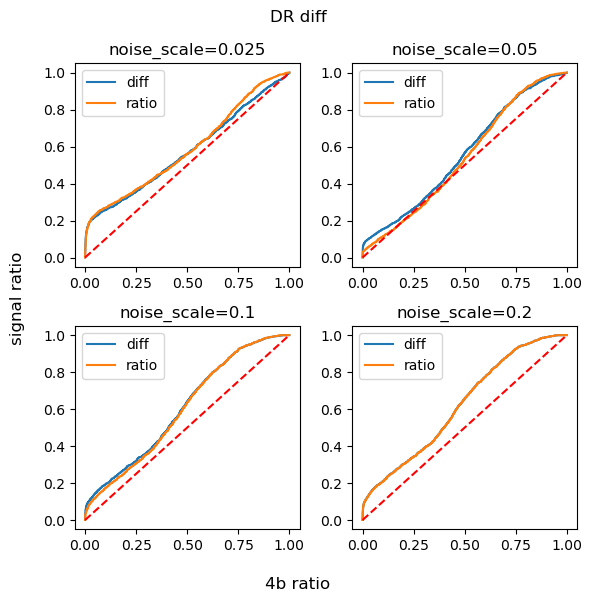

In [6]:
import logging
import tqdm
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
logging.getLogger("lightning").setLevel(logging.WARNING)

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

n_sample_ratio = 1.0
device = torch.device("cuda:0")
noise_scales = [0.025, 0.05, 0.1, 0.2]
dr_dict = {seed: {} for seed in seeds}
events_3_dict = {seed: {} for seed in seeds}

for seed in seeds:
    print("seed", seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    events = events_test_dict[seed]
    fvt_scores = fvt_scores_dict[seed][n_sample_ratio]
    att_q_reprs = att_q_reprs_dict[seed][n_sample_ratio]

    idxs = np.arange(len(events)) % 3
    idxs = idxs[np.random.permutation(len(idxs))]

    events_1 = events[idxs == 0]
    events_2 = events[idxs == 1]
    events_3 = events[idxs == 2]

    events_3_dict[seed] = events_3.clone()

    X_1 = att_q_reprs[idxs == 0]
    X_2 = att_q_reprs[idxs == 1]
    X_3 = att_q_reprs[idxs == 2]

    y_1 = events_1.is_4b
    y_2 = events_2.is_4b
    y_3 = events_3.is_4b

    is_signal_1 = events_1.is_signal
    is_signal_2 = events_2.is_signal
    is_signal_3 = events_3.is_signal

    
    nrows = 2
    ncols = int(np.ceil(len(noise_scales) / 2))

    fig0, ax0 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))
    fig0.supxlabel("DR diff")
    fig0.supylabel("count")
    
    fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))
    fig1.supxlabel("DR ratio")
    fig1.supylabel("count")

    fig2, ax2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))
    fig2.suptitle("DR diff")
    fig2.supxlabel("4b ratio")
    fig2.supylabel("signal ratio")

    clf1 = MLPClassifierTorch(input_size=6, hidden_size=2**7, 
                                  num_classes=2, random_state=seed)
    clf1.to(device)
    clf1.fit(X_1, y_1, events_1.weights)

    prob1 = clf1.predict_proba(X_3)
    dr_1 = prob1[:, 1] / prob1[:, 0]

    dr_dict[seed][0] = dr_1
    
    for ax_cnt, noise_scale in enumerate(noise_scales):
        current_ax0 = ax0[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax0[ax_cnt]
        current_ax1 = ax1[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax1[ax_cnt]
        current_ax2 = ax2[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax2[ax_cnt]

        X_2 = X_2 + np.random.normal(0, 1, X_2.shape) * (np.max(X_2, axis=0) - np.min(X_2, axis=0)) * noise_scale

        
        clf2 = MLPClassifierTorch(input_size=6, hidden_size=2**7, 
                                  num_classes=2, random_state=seed)
        clf2.to(device)
        clf2.fit(X_2, y_2, events_2.weights)
        
        prob2 = clf2.predict_proba(X_3)        
        dr_2 = prob2[:, 1] / prob2[:, 0]

        dr_dict[seed][noise_scale] = dr_2

        dr_diff = dr_1 - dr_2
        dr_diff_argsort = np.argsort(dr_diff)[::-1]

        dr_ratio = dr_1 / dr_2
        dr_ratio_argsort = np.argsort(dr_ratio)[::-1]

        bins_range = np.linspace(np.min(dr_diff), np.max(dr_diff), 20)
        current_ax0.set_title(f"noise_scale={noise_scale}")
        current_ax0.hist(dr_diff[events_3.is_3b], bins=bins_range, label="3b", histtype="step")
        current_ax0.hist(dr_diff[events_3.is_bg4b], bins=bins_range, label="bg4b", histtype="step")
        current_ax0.hist(dr_diff[events_3.is_signal], bins=bins_range, label="signal", histtype="step")
        current_ax0.set_yscale("log")
        
        bins_range = np.linspace(np.min(dr_ratio), np.max(dr_ratio), 20)
        current_ax1.set_title(f"noise_scale={noise_scale}")
        current_ax1.hist(dr_ratio[events_3.is_3b], bins=bins_range, label="3b", histtype="step")
        current_ax1.hist(dr_ratio[events_3.is_bg4b], bins=bins_range, label="bg4b", histtype="step")
        current_ax1.hist(dr_ratio[events_3.is_signal], bins=bins_range, label="signal", histtype="step")
        current_ax1.set_yscale("log")

        current_ax2.set_title(f"noise_scale={noise_scale}")
        current_ax2.plot(
            np.cumsum(events_3.is_4b[dr_diff_argsort]) / np.sum(events_3.is_4b),
            np.cumsum(events_3.is_signal[dr_diff_argsort]) / np.sum(events_3.is_signal),
            label="diff",
        )
        current_ax2.plot(
            np.cumsum(events_3.is_4b[dr_ratio_argsort]) / np.sum(events_3.is_4b),
            np.cumsum(events_3.is_signal[dr_ratio_argsort]) / np.sum(events_3.is_signal),
            label="ratio",
        )
        current_ax2.plot([0, 1], [0, 1], linestyle="--", color="red")
        current_ax2.legend()

    fig0.tight_layout()
    fig0.show()
    fig1.tight_layout()
    fig1.show()
    fig2.tight_layout()
    fig2.show()
    plt.show()

************ seed 42


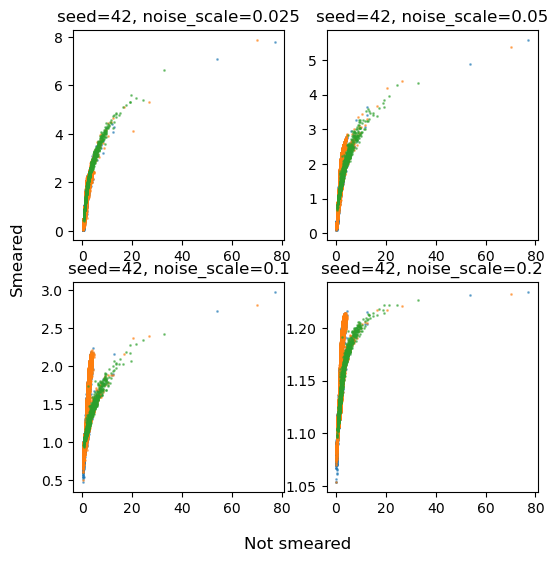

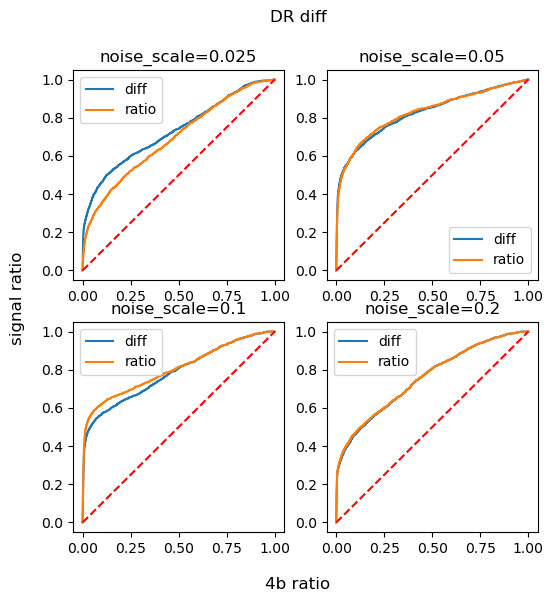

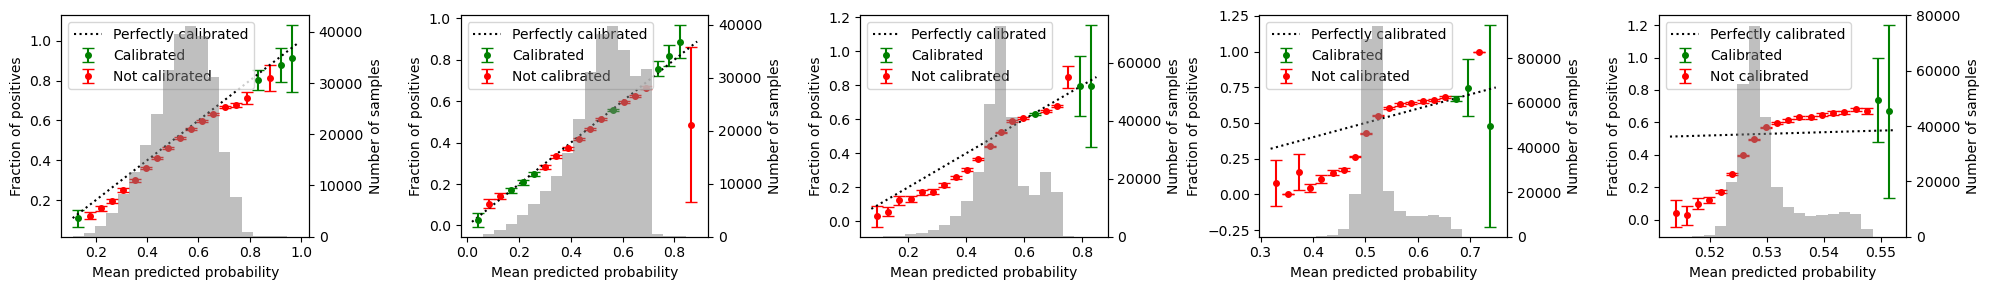

************ seed 52


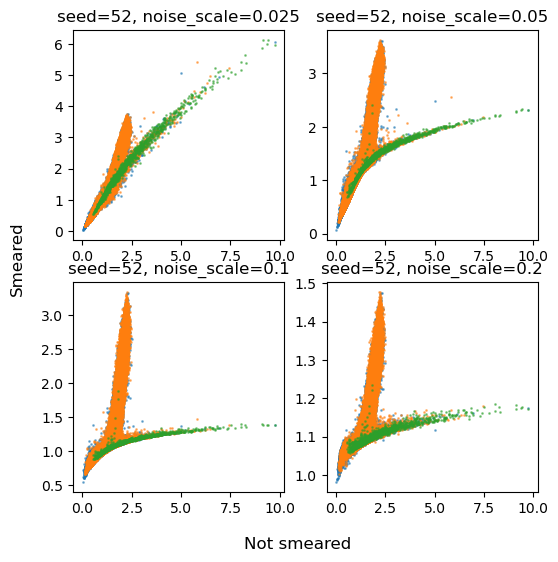

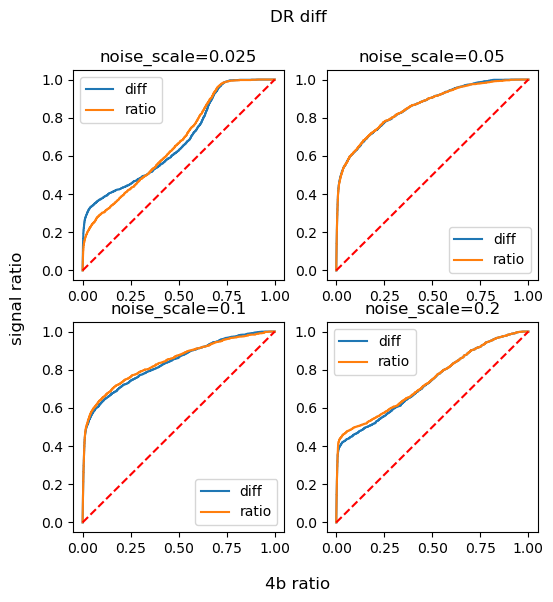

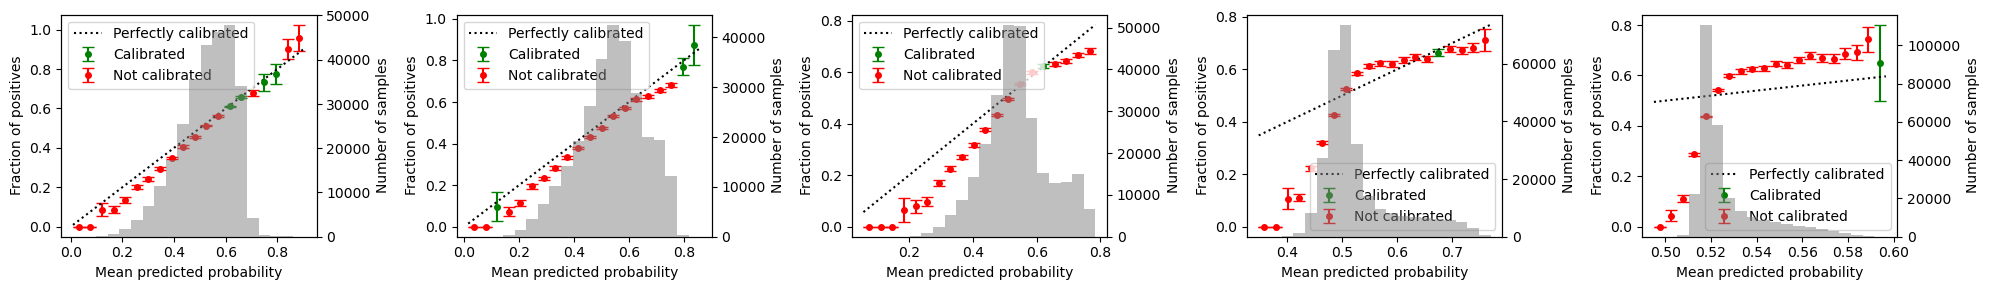

************ seed 62


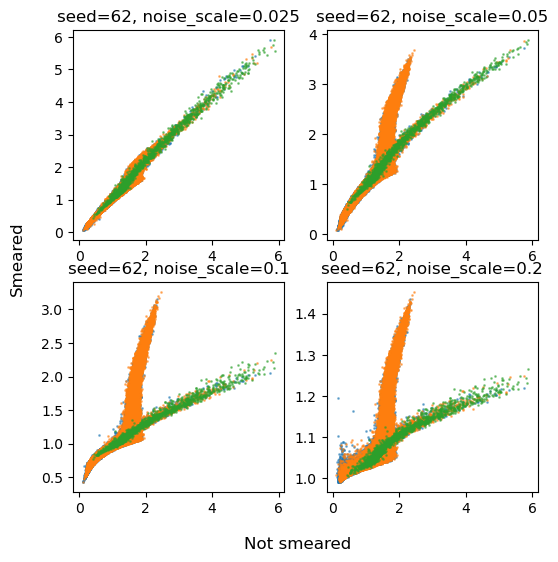

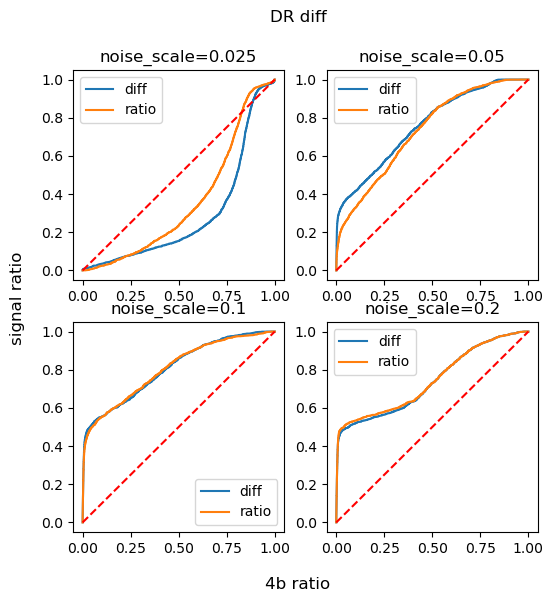

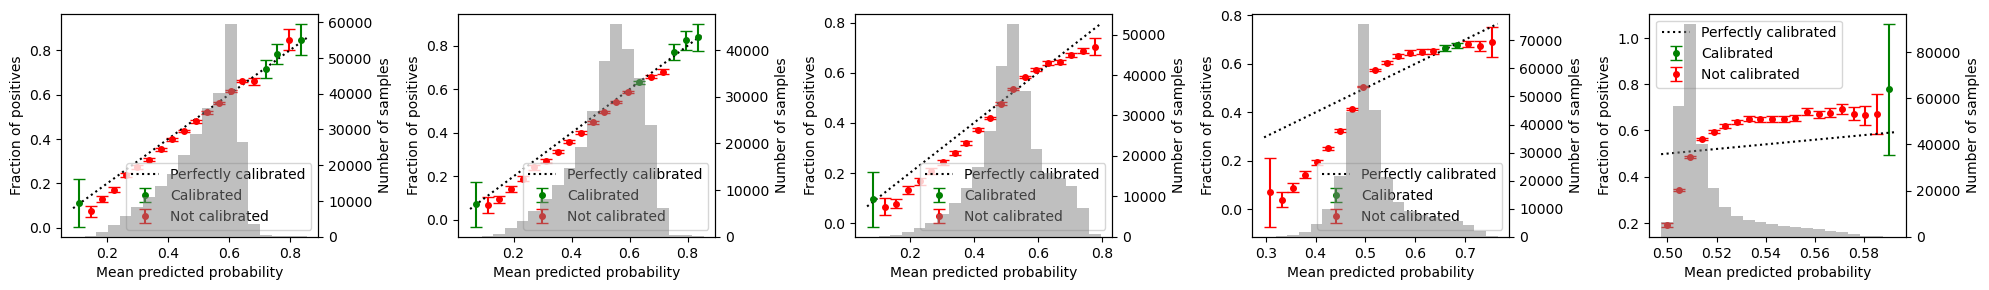

************ seed 72


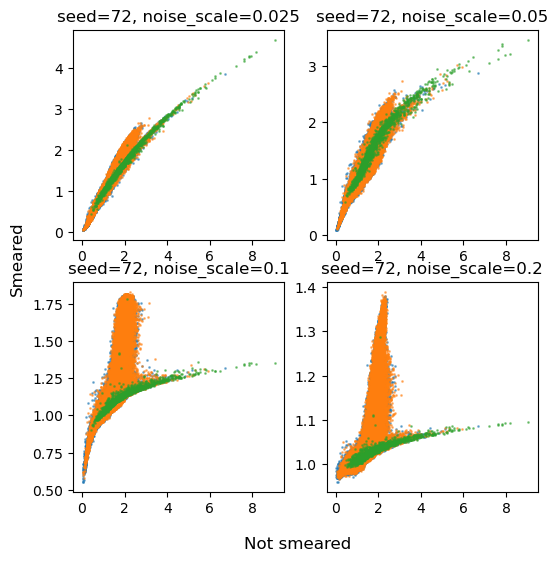

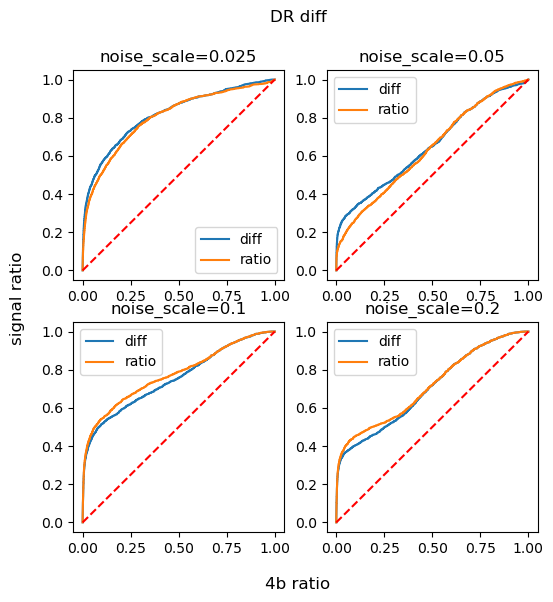

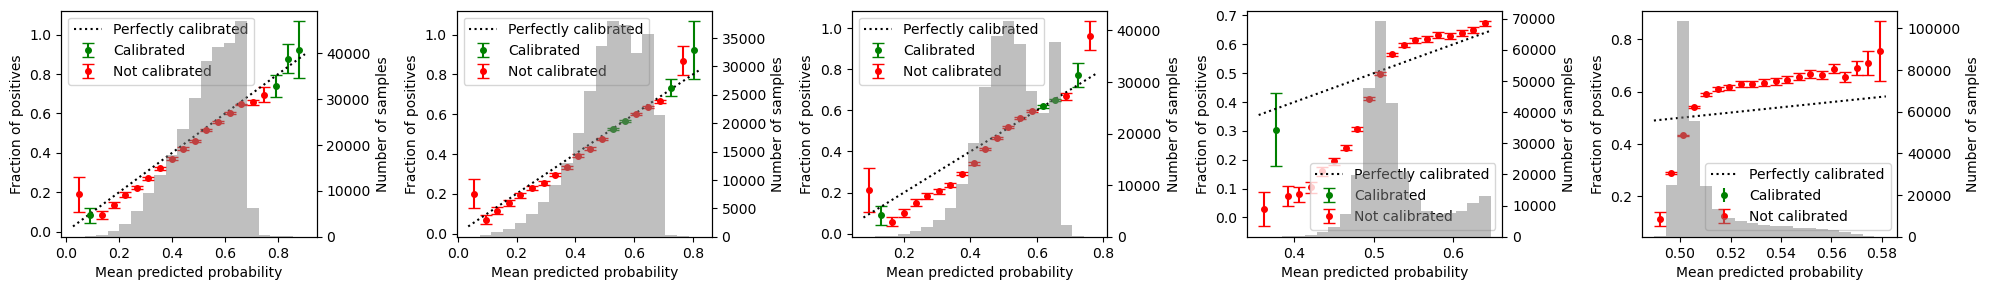

************ seed 82


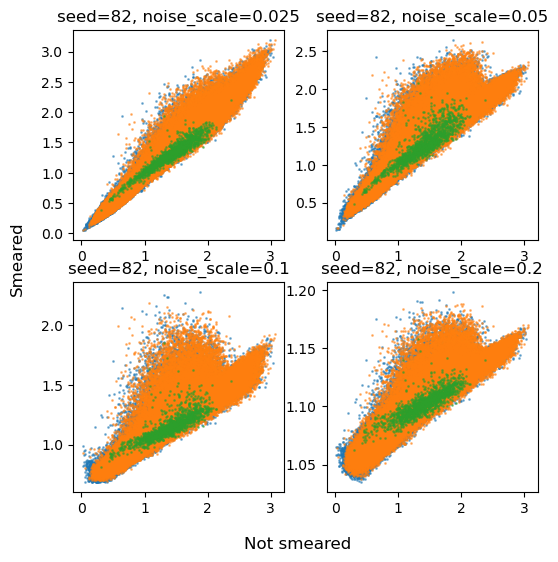

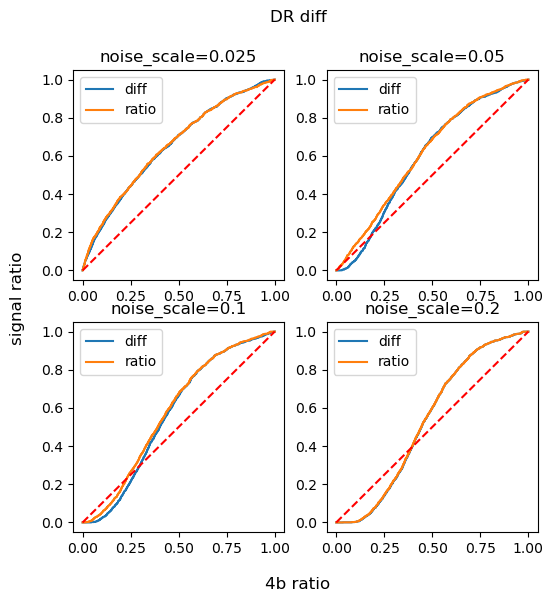

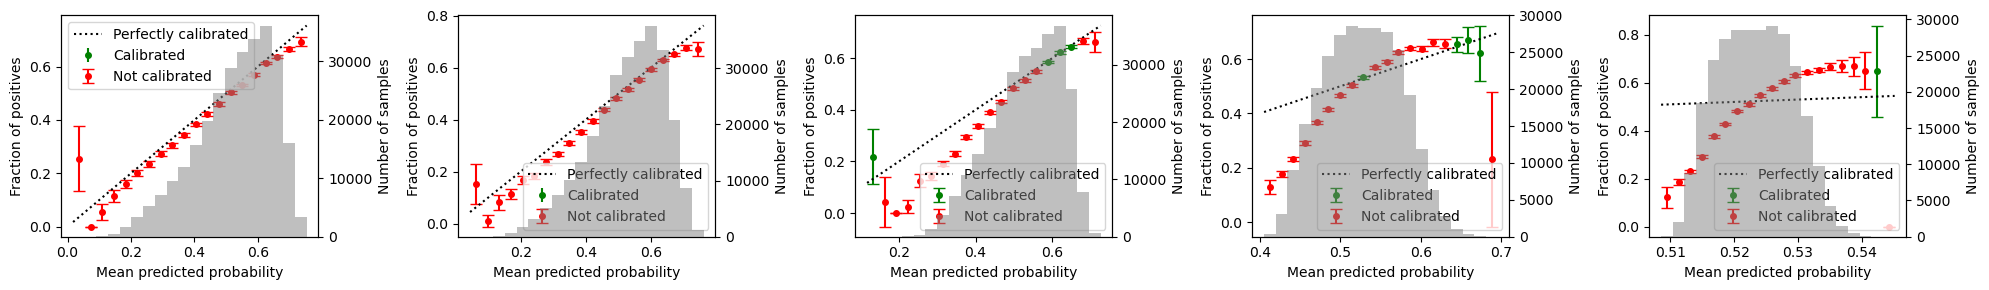

************ seed 92


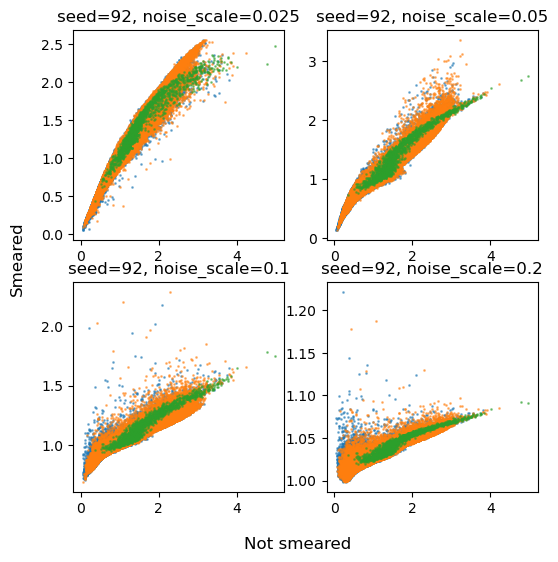

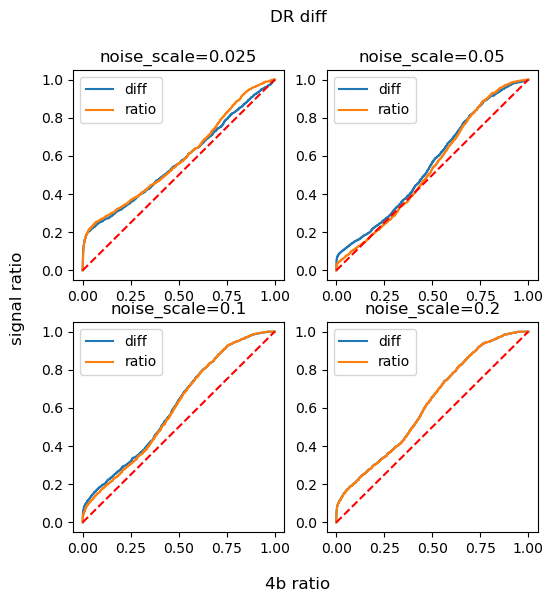

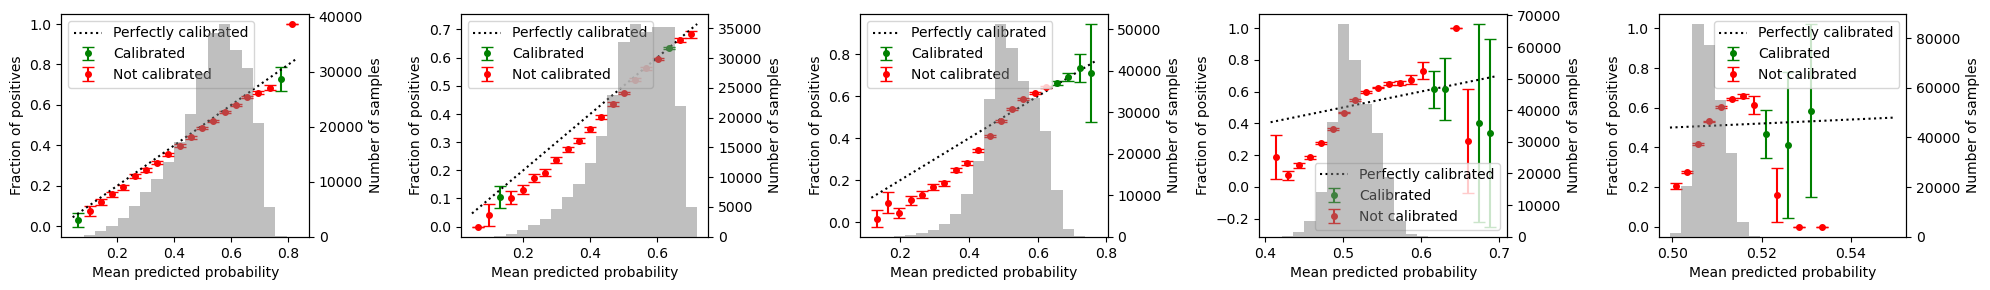

In [7]:
from plots import calibration_plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for seed in seeds:
    print("************ seed", seed)
    
    events_3 = events_3_dict[seed]
    
    nrows = 2
    ncols = int(np.ceil(len(noise_scales) / 2))
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))
    fig.supxlabel("Not smeared")
    fig.supylabel("Smeared")

    fig2, ax2 = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows))
    fig2.suptitle("DR diff")
    fig2.supxlabel("4b ratio")
    fig2.supylabel("signal ratio")

    cal_fig, cal_ax = plt.subplots(nrows=1, ncols=len(noise_scales) + 1, figsize=(4 * (len(noise_scales) + 1), 3))

    dr_1 = dr_dict[seed][0]
    calibration_plot(dr_1 / (1 + dr_1), events_3.is_4b, sample_weights=events_3.weights, bins=20, ax=cal_ax[0])

    for ax_cnt, noise_scale in enumerate(noise_scales):
        dr_2 = dr_dict[seed][noise_scale]
        calibration_plot(dr_2 / (1 + dr_2), events_3.is_4b, sample_weights=events_3.weights, bins=20, ax=cal_ax[ax_cnt + 1])
    
    
    for ax_cnt, noise_scale in enumerate(noise_scales):
        current_ax = ax[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax[ax_cnt]
        current_ax2 = ax2[ax_cnt // ncols, ax_cnt % ncols] if ncols > 1 else ax2[ax_cnt]


        dr_1 = dr_dict[seed][0]
        dr_2 = dr_dict[seed][noise_scale]


        
        current_ax.set_title(f"seed={seed}, noise_scale={noise_scale}")


        is_signal = events_3.is_signal
        is_bg4b = events_3.is_bg4b
        is_3b = events_3.is_3b
        
        current_ax.scatter(dr_1[is_3b], dr_2[is_3b], label="3b", alpha=0.5, s=1)
        current_ax.scatter(dr_1[is_bg4b], dr_2[is_bg4b], label="bg4b", alpha=0.5, s=1)
        current_ax.scatter(dr_1[is_signal], dr_2[is_signal], label="signal", alpha=0.5, s=1)
        

        dr_diff = dr_1 - dr_2
        dr_diff_argsort = np.argsort(dr_diff)[::-1]

        dr_ratio = dr_1 / dr_2
        dr_ratio_argsort = np.argsort(dr_ratio)[::-1]

        current_ax2.set_title(f"noise_scale={noise_scale}")
        current_ax2.plot(
            np.cumsum(events_3.is_4b[dr_diff_argsort]) / np.sum(events_3.is_4b),
            np.cumsum(events_3.is_signal[dr_diff_argsort]) / np.sum(events_3.is_signal),
            label="diff",
        )
        current_ax2.plot(
            np.cumsum(events_3.is_4b[dr_ratio_argsort]) / np.sum(events_3.is_4b),
            np.cumsum(events_3.is_signal[dr_ratio_argsort]) / np.sum(events_3.is_signal),
            label="ratio",
        )
        current_ax2.plot([0, 1], [0, 1], linestyle="--", color="red")
        current_ax2.legend()

        
    plt.tight_layout()    
    plt.show()


    

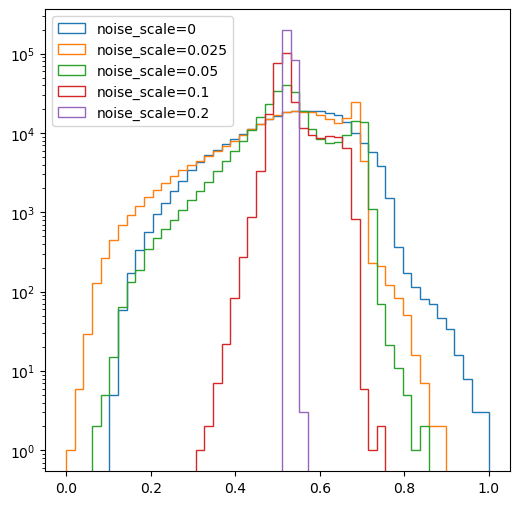

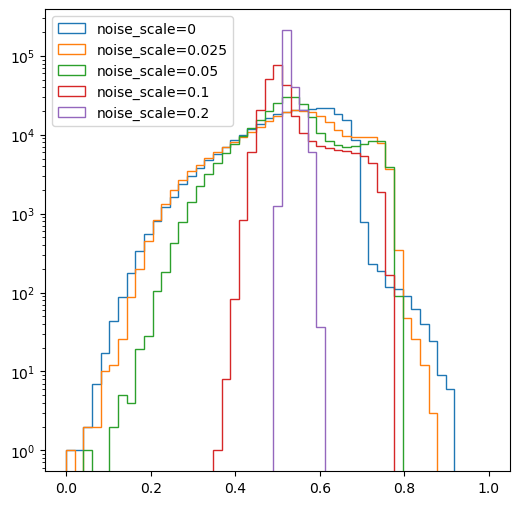

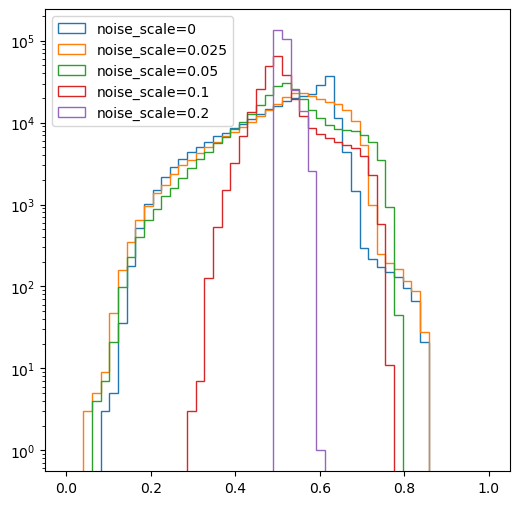

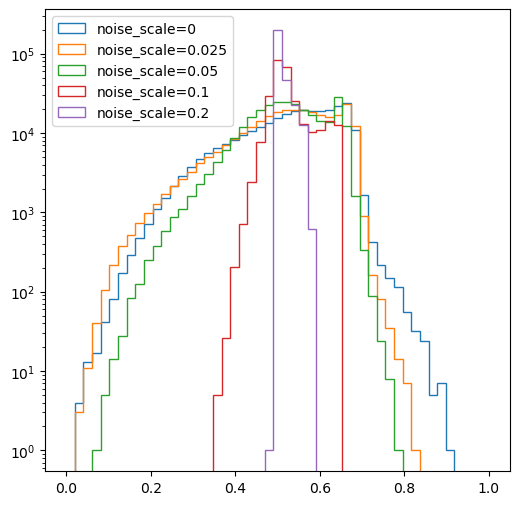

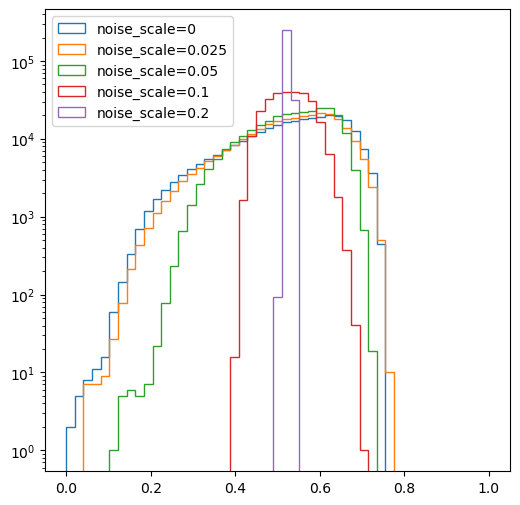

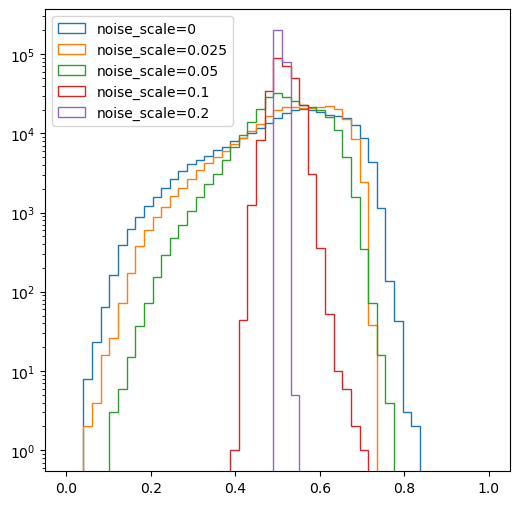

In [8]:
for seed in seeds:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    events_3 = events_3_dict[seed]

    bins_range = np.linspace(0, 1, 50)
    
    for noise_scale in [0] + noise_scales:
        dr = dr_dict[seed][noise_scale]
        ax.hist(dr / (1 + dr), bins=bins_range, histtype="step", label=f"noise_scale={noise_scale}")

    

    ax.legend()
    ax.set_yscale("log")

    plt.show()




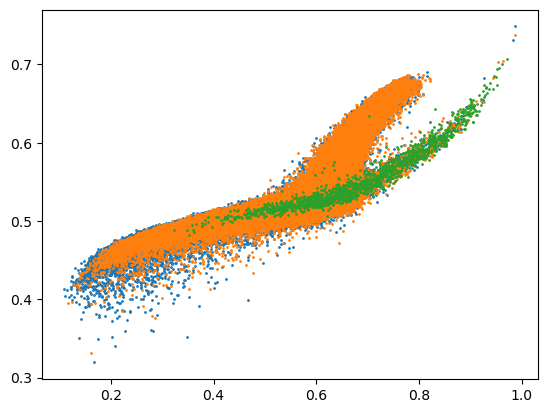

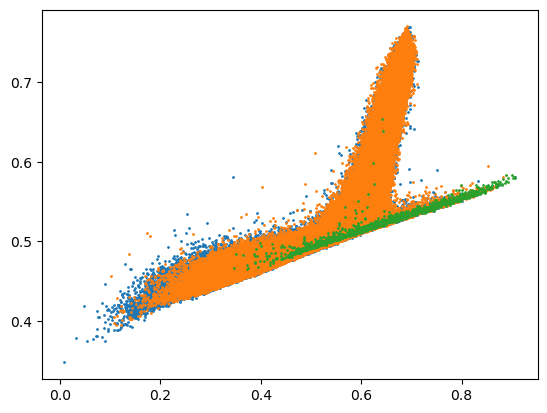

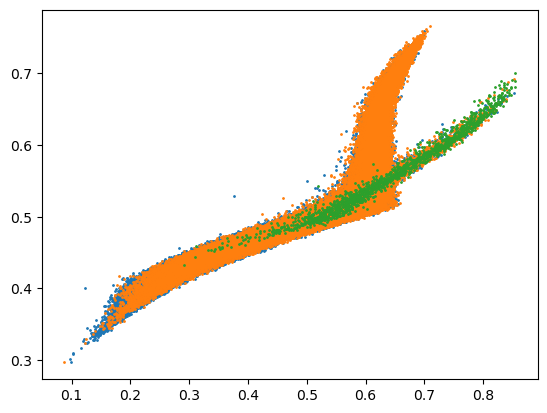

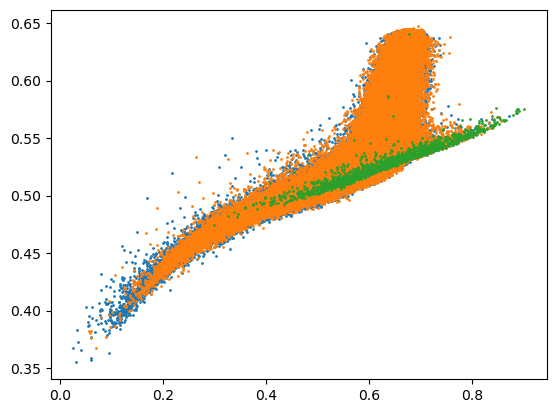

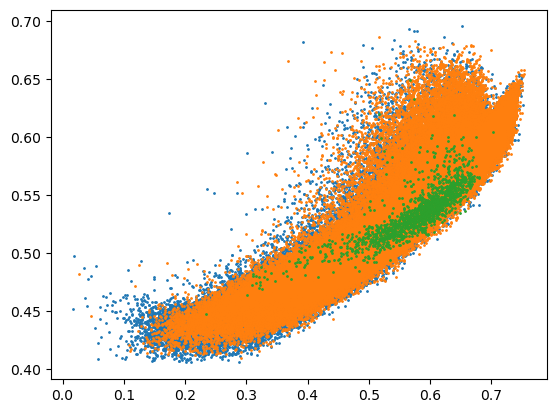

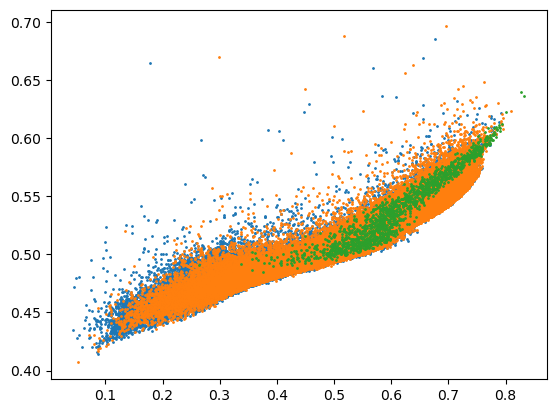

In [9]:
noise_scale_1 = 0.0
noise_scale_2 = 0.1

for seed in seeds:
    events_3 = events_3_dict[seed]
    is_3b = events_3.is_3b
    is_bg4b = events_3.is_bg4b
    is_signal = events_3.is_signal

    dr_n1 = dr_dict[seed][noise_scale_1]
    dr_n2 = dr_dict[seed][noise_scale_2]

    plt.scatter((dr_n1 / (1 + dr_n1))[is_3b], (dr_n2 / (1 + dr_n2))[is_3b], label="3b", s=1)
    plt.scatter((dr_n1 / (1 + dr_n1))[is_bg4b], (dr_n2 / (1 + dr_n2))[is_bg4b], label="bg4b", s=1)
    plt.scatter((dr_n1 / (1 + dr_n1))[is_signal], (dr_n2 / (1 + dr_n2))[is_signal], label="signal", s=1)
    plt.show()

    

seed 42


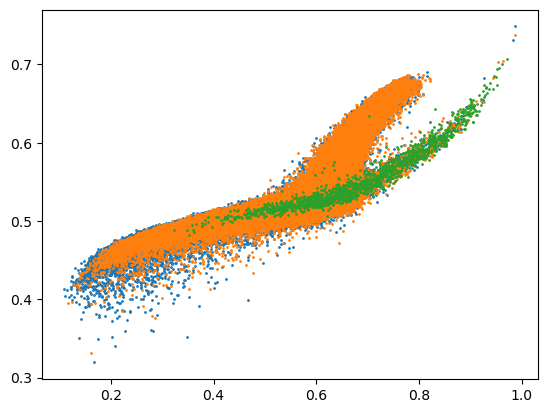

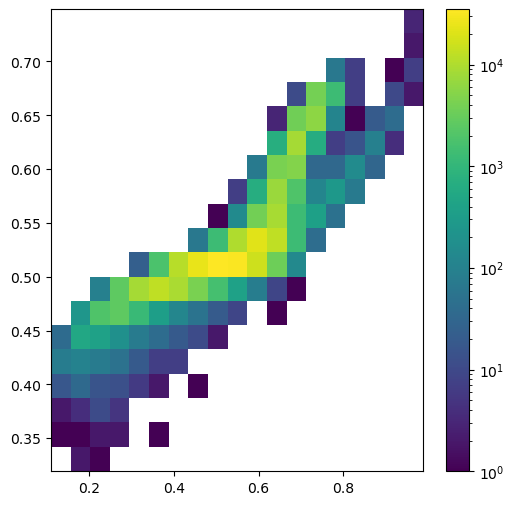

/tmp/ipykernel_1254427/557931526.py:41: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow((hist_signal / hist_4b).T, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), aspect="auto")


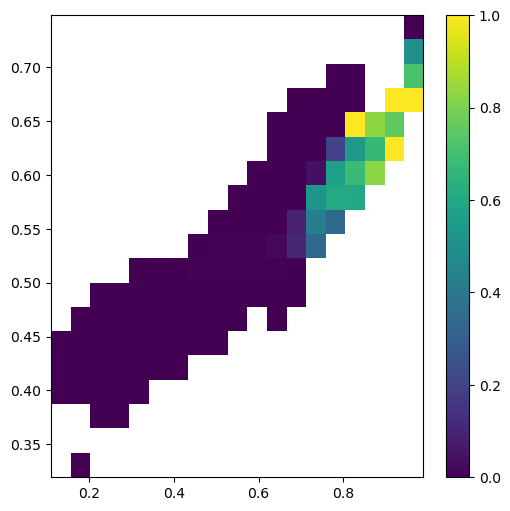

/tmp/ipykernel_1254427/557931526.py:46: RuntimeWarning: invalid value encountered in divide
  im = ax.imshow((hist_4b / hist_all).T, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), aspect="auto")


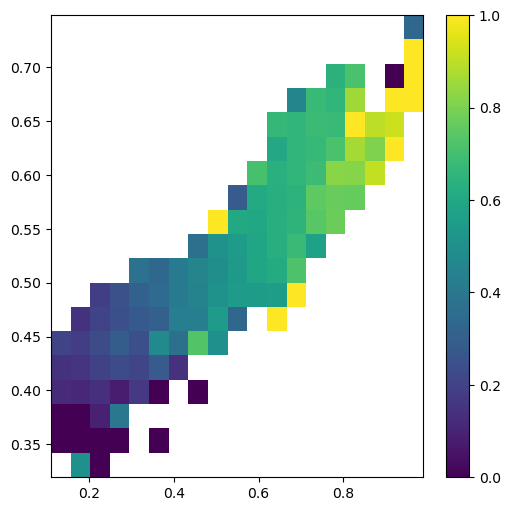

seed 52


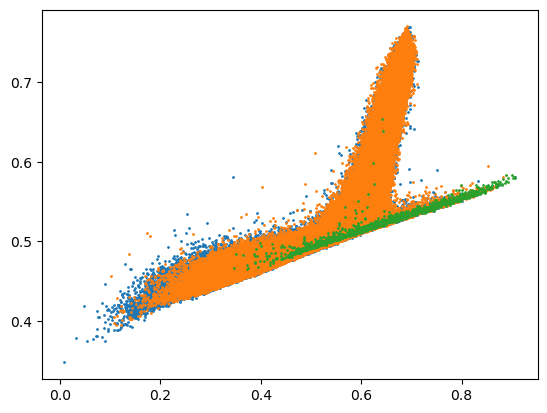

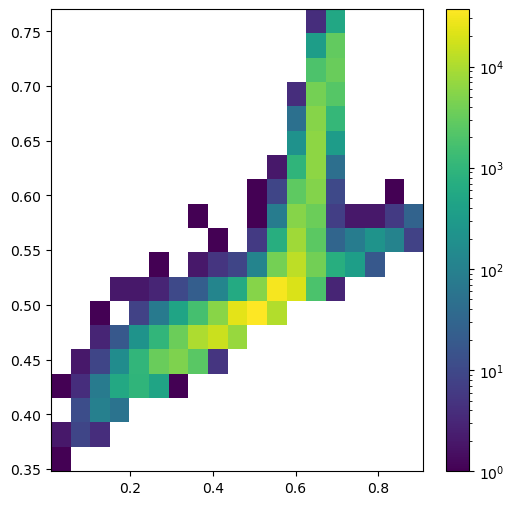

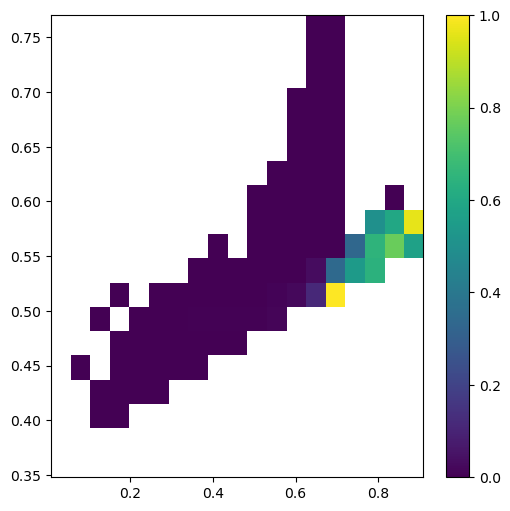

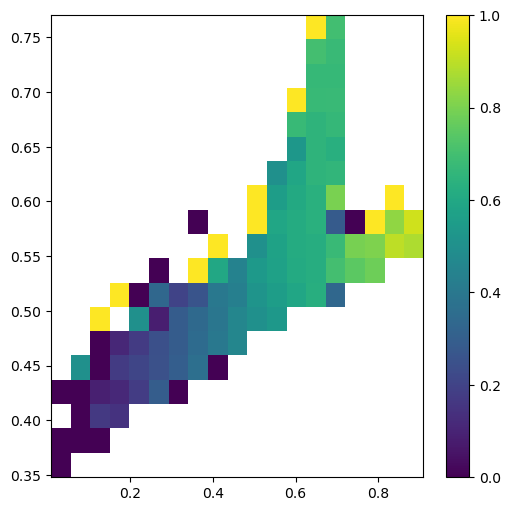

seed 62


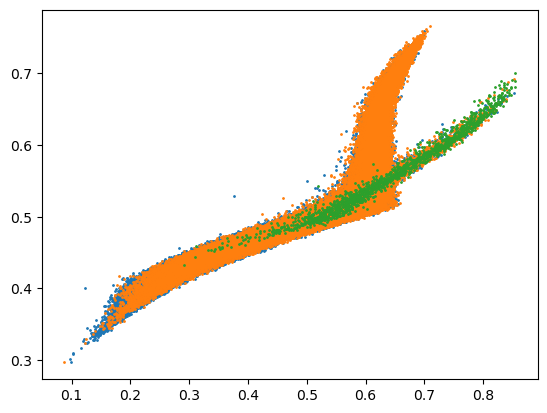

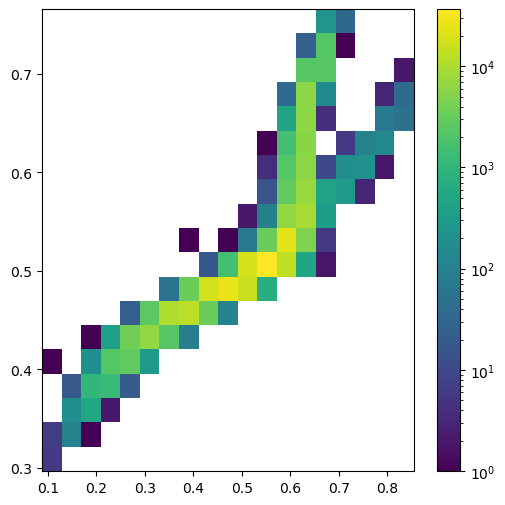

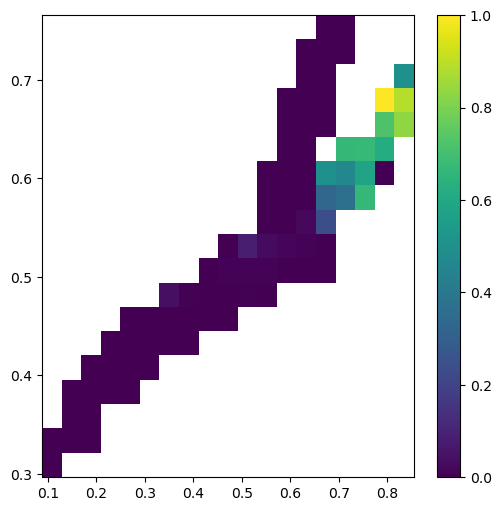

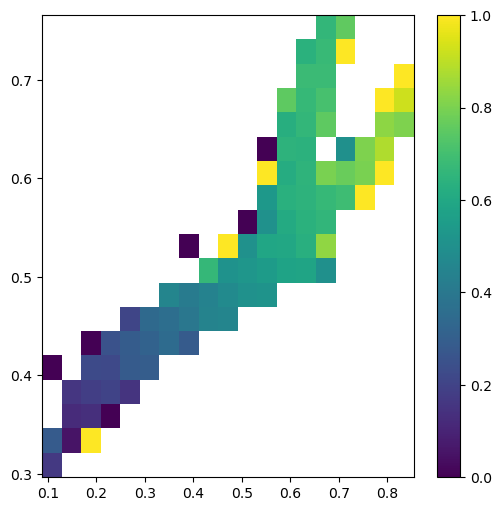

seed 72


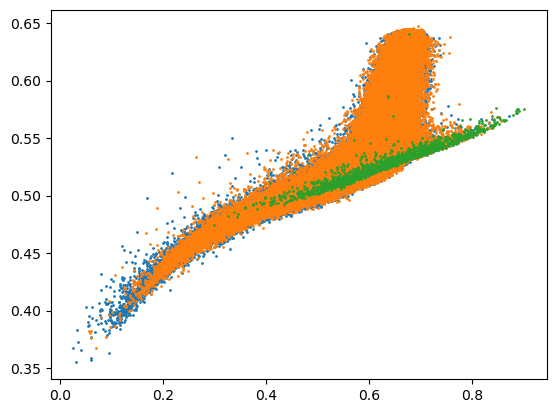

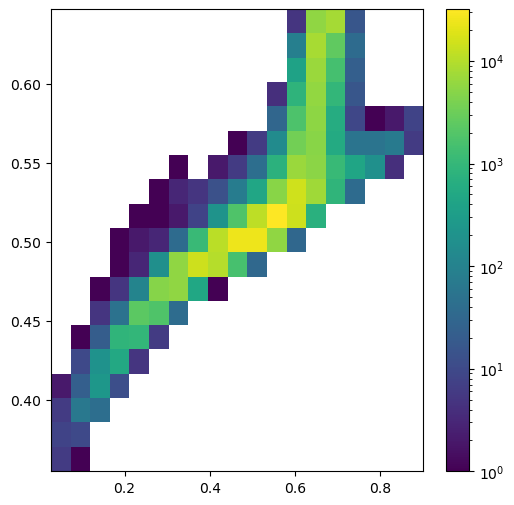

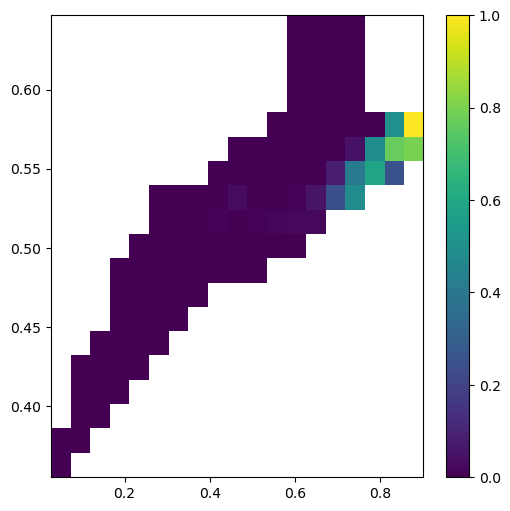

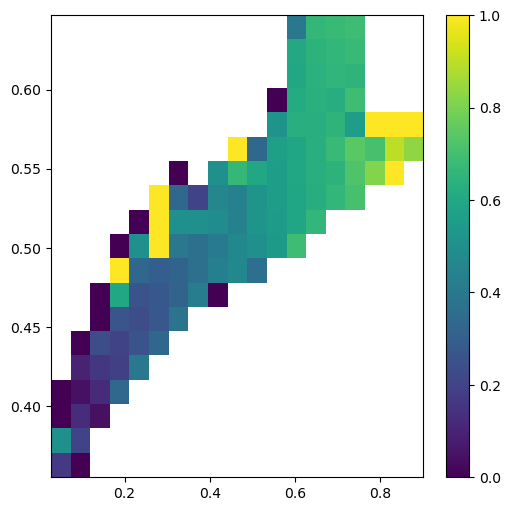

seed 82


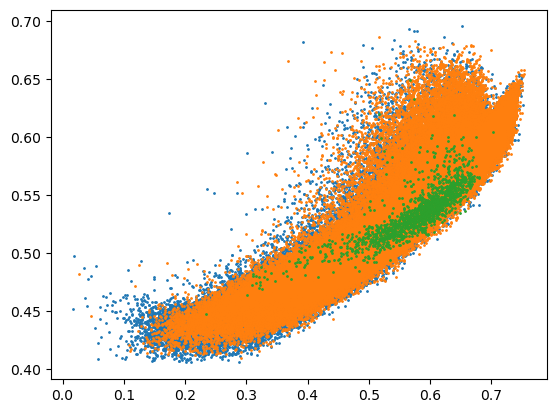

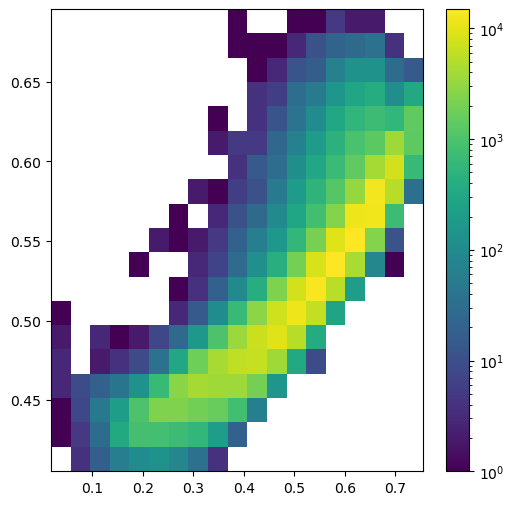

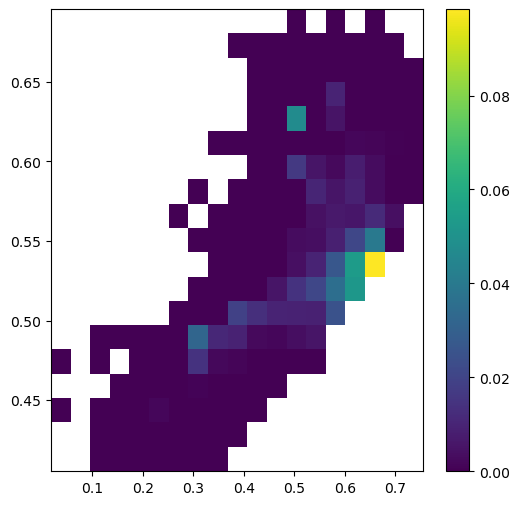

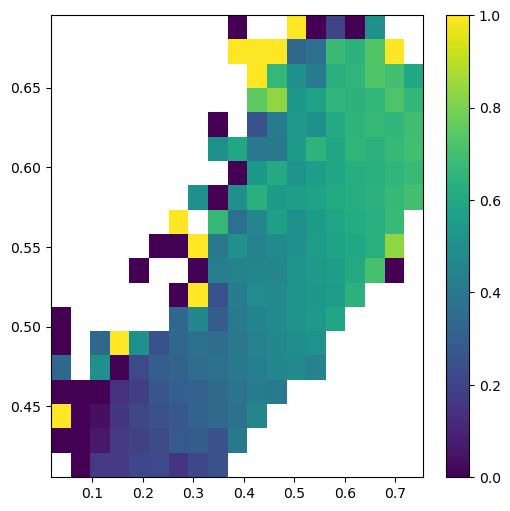

seed 92


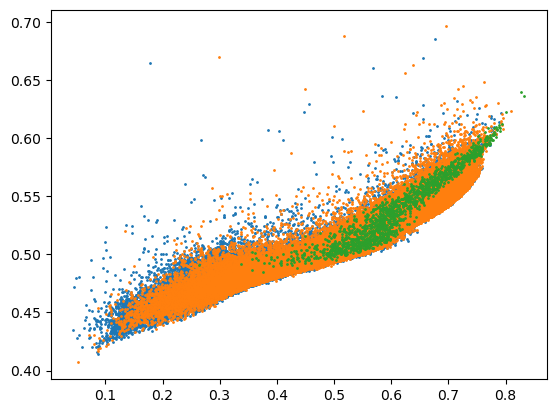

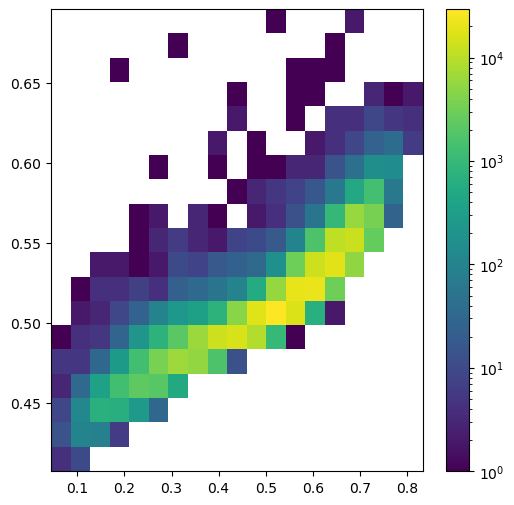

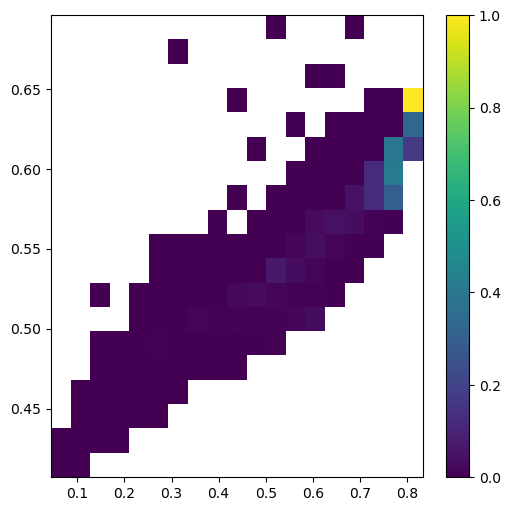

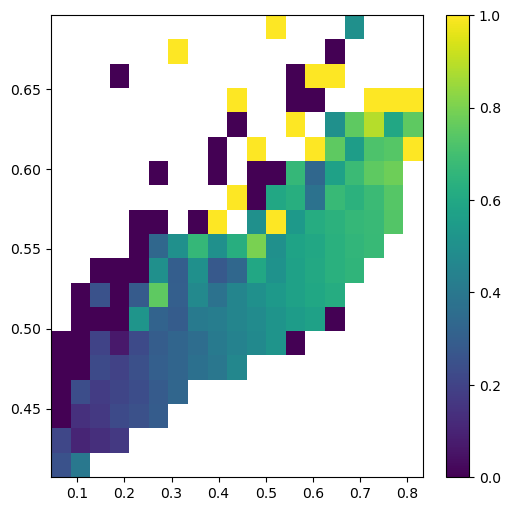

In [10]:
import matplotlib

noise_scale_1 = 0.0
noise_scale_2 = 0.1
mode = "4b" # "4b" / "4b/3b"


for seed in seeds:
    print("seed", seed)
    events_3 = events_3_dict[seed]
    is_3b = events_3.is_3b
    is_bg4b = events_3.is_bg4b
    is_signal = events_3.is_signal

    dr_n1 = dr_dict[seed][noise_scale_1]
    dr_n2 = dr_dict[seed][noise_scale_2]

    v1 = (dr_n1 / (1 + dr_n1)) if mode == "4b" else dr_n1
    v2 = (dr_n2 / (1 + dr_n2)) if mode == "4b" else dr_n2

    plt.scatter(v1[is_3b], v2[is_3b], label="3b", s=1)
    plt.scatter(v1[is_bg4b], v2[is_bg4b], label="bg4b", s=1)
    plt.scatter(v1[is_signal], v2[is_signal], label="signal", s=1)
    plt.show()

    x_bins, y_bins = np.linspace(np.min(v1), np.max(v1), 20), np.linspace(np.min(v2), np.max(v2), 20)
    hist_3b, _, _ = np.histogram2d(v1[is_3b], v2[is_3b], bins=(x_bins, y_bins))
    hist_bg4b, _, _ = np.histogram2d(v1[is_bg4b], v2[is_bg4b], bins=(x_bins, y_bins))
    hist_signal, _, _ = np.histogram2d(v1[is_signal], v2[is_signal], bins=(x_bins, y_bins))
    hist_4b = hist_bg4b + hist_signal
    hist_all = hist_3b + hist_bg4b + hist_signal

    # log scale color
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    im = ax.imshow(hist_all.T, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), aspect="auto", 
                   norm=matplotlib.colors.LogNorm())
    fig.colorbar(im)
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    im = ax.imshow((hist_signal / hist_4b).T, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), aspect="auto")
    fig.colorbar(im)
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    im = ax.imshow((hist_4b / hist_all).T, origin="lower", extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), aspect="auto")
    fig.colorbar(im)
    plt.show()




seed 42


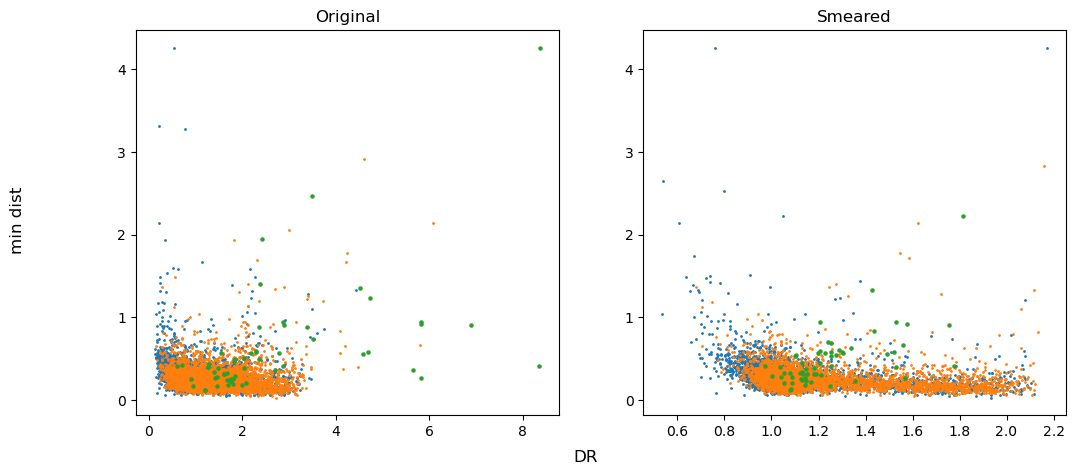

seed 52


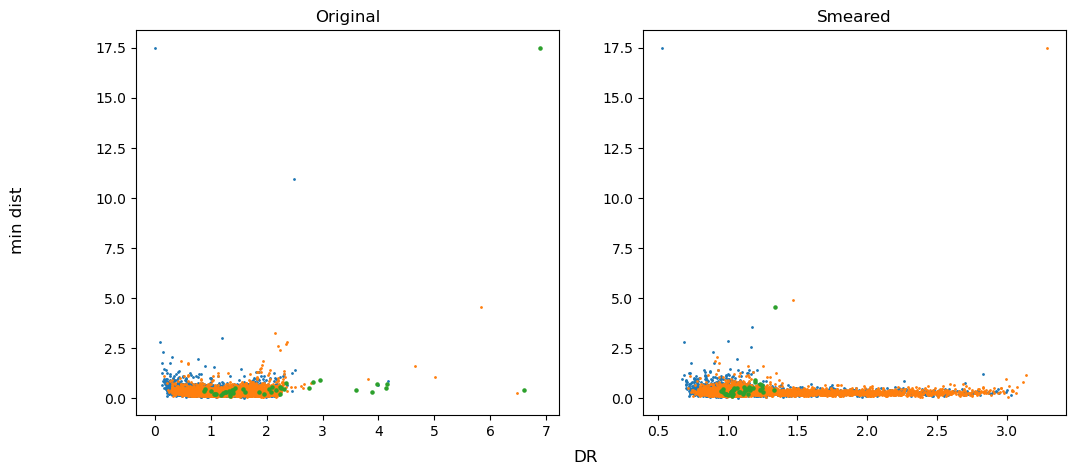

seed 62


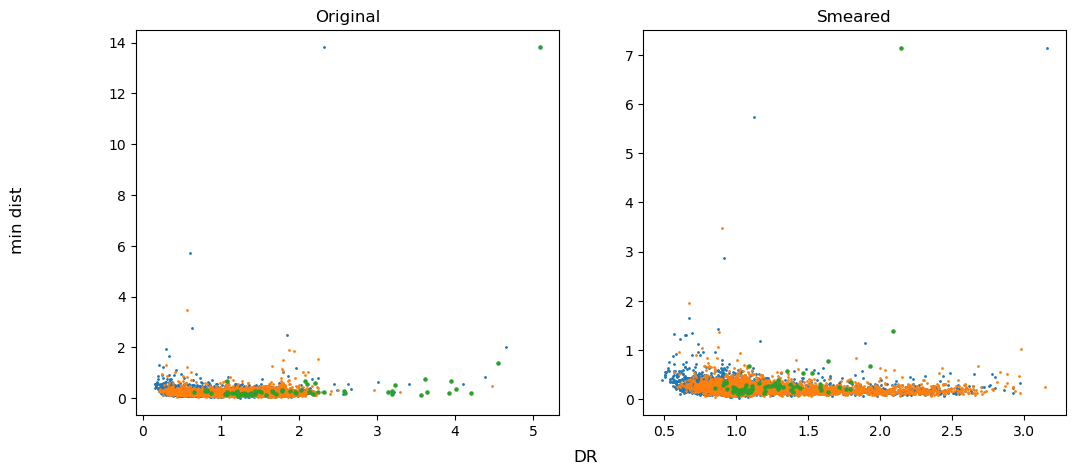

seed 72


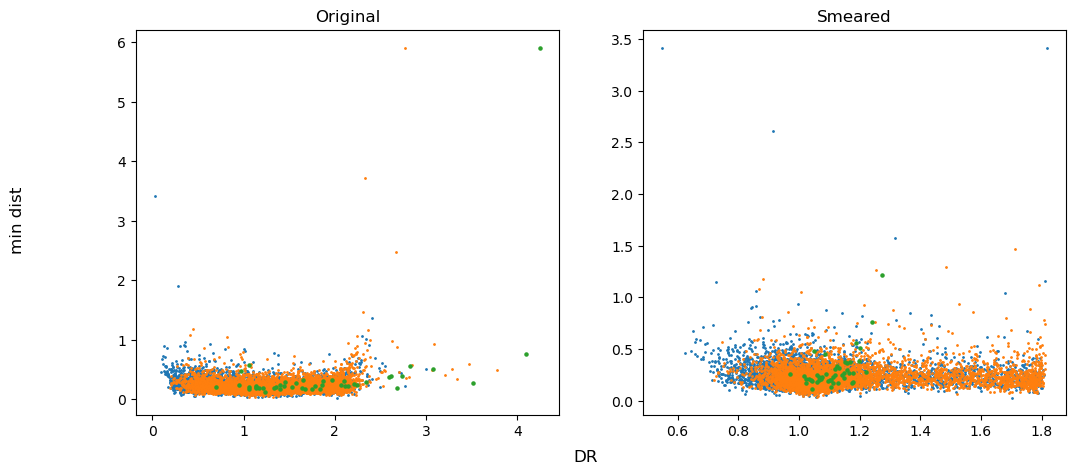

seed 82


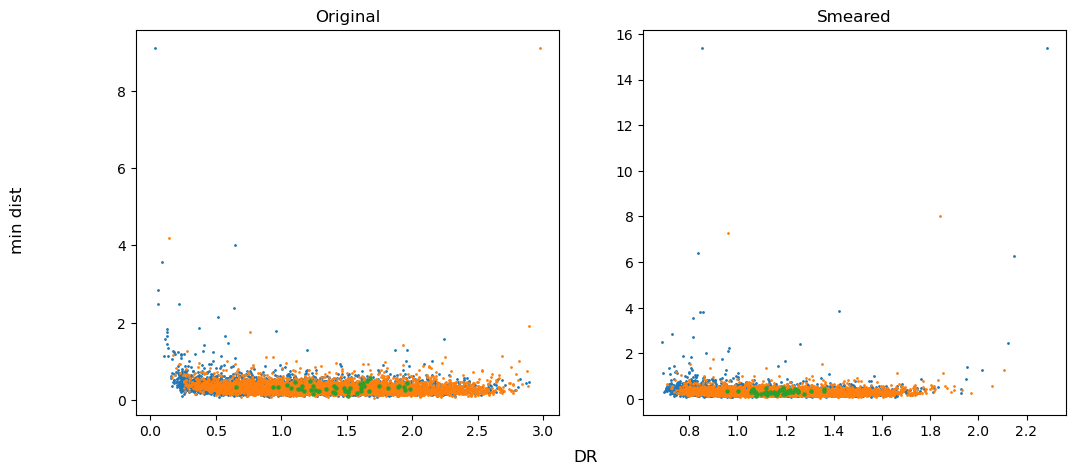

seed 92


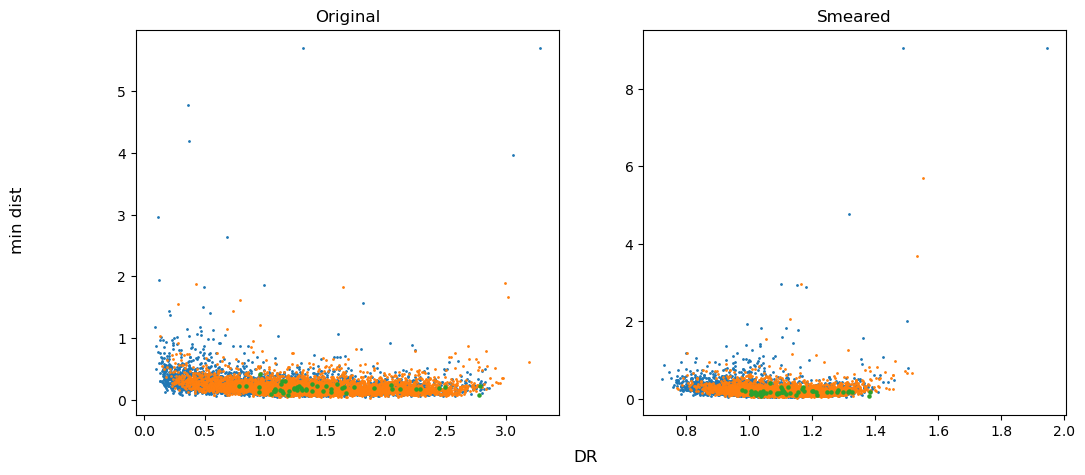

In [11]:
import cudf
from cuml.neighbors import NearestNeighbors
import multiprocessing as mp

n_workers = 4
noise_scale = 0.1
pct = 0.01

for seed in seeds:  
    print("seed", seed)

    dr_1 = dr_dict[seed][0]
    dr_2 = dr_dict[seed][noise_scale]

    n_points = 10_000
    np.random.seed(seed)
    events = events_3_dict[seed]
    X = events.att_q_repr.copy()
    idx = np.random.choice(X.shape[0], n_points, replace=False, p=events.weights / events.weights.sum())
    events_sampled = events[idx]
    X = X[idx]
    is_3b = events_sampled.is_3b
    is_bg4b = events_sampled.is_bg4b
    is_signal = events_sampled.is_signal


    n_neighbors = int(n_points * pct)
    X_cudf = cudf.DataFrame(X)
    model = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", metric="euclidean")
    nbrs = model.fit(X_cudf)
    distances, indices = nbrs.kneighbors(X_cudf)
    distances = distances.to_numpy()
    indices = indices.to_numpy()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.supxlabel("DR")
    fig.supylabel("min dist")


    for ax_cnt, rho in enumerate([dr_1[idx], dr_2[idx]]):
        current_ax = ax[ax_cnt]
        min_dists = np.inf * np.ones(n_points)
        rho_argsort = np.argsort(rho)[::-1]
        dist_func = lambda x, y: np.linalg.norm(x - y, axis=1)

        def min_dist_fn(i):
            if i == 0:
                return np.inf
            else:
                return np.min(dist_func(X[rho_argsort[i]], X[rho_argsort[:i]]))

        with mp.Pool(n_workers) as pool:
            min_dists = np.array(pool.map(min_dist_fn, np.arange(n_points)))

        min_dists[rho_argsort] = min_dists.copy()
        min_dists[np.isinf(min_dists)] = np.max(min_dists[~np.isinf(min_dists)]) # replace inf with max

        current_ax.scatter(rho[is_3b], min_dists[is_3b], s=1, label="3b")
        current_ax.scatter(rho[is_bg4b], min_dists[is_bg4b], s=1, label="bg4b")
        current_ax.scatter(rho[is_signal], min_dists[is_signal], s=5, label="signal")
        current_ax.set_title("Smeared" if ax_cnt == 1 else "Original")

    
    plt.show()
    plt.close()

seed 42


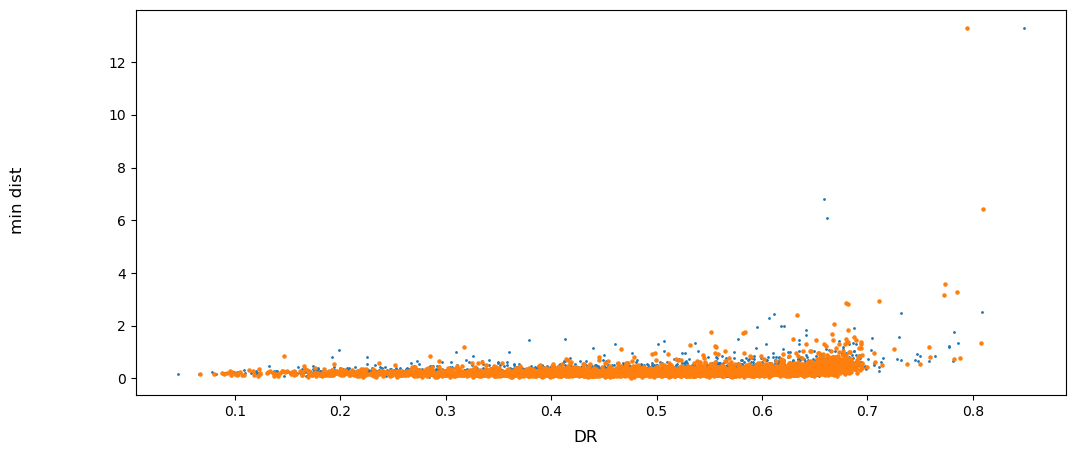

seed 52


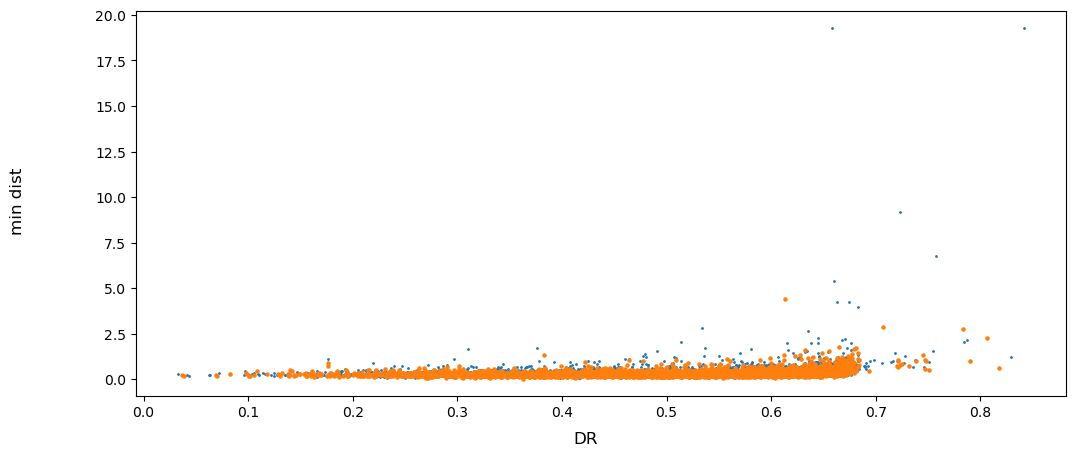

seed 62


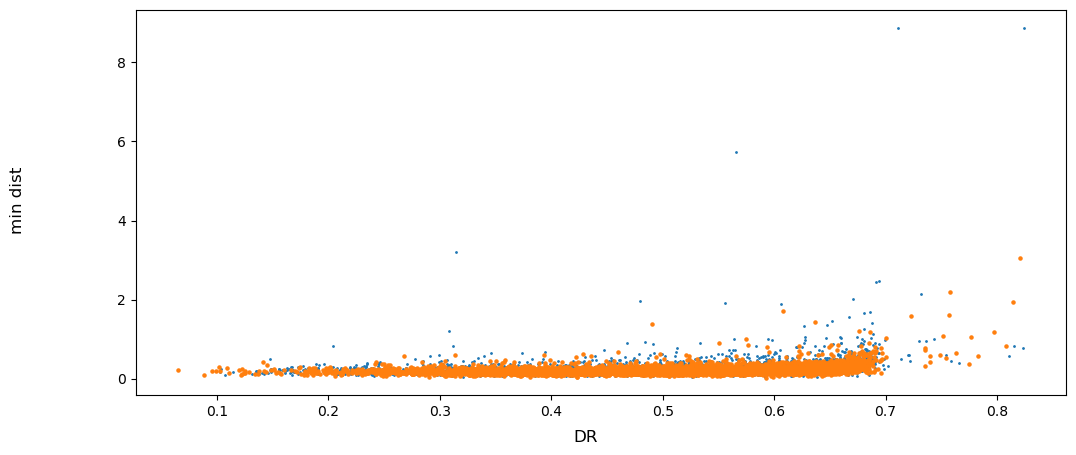

seed 72


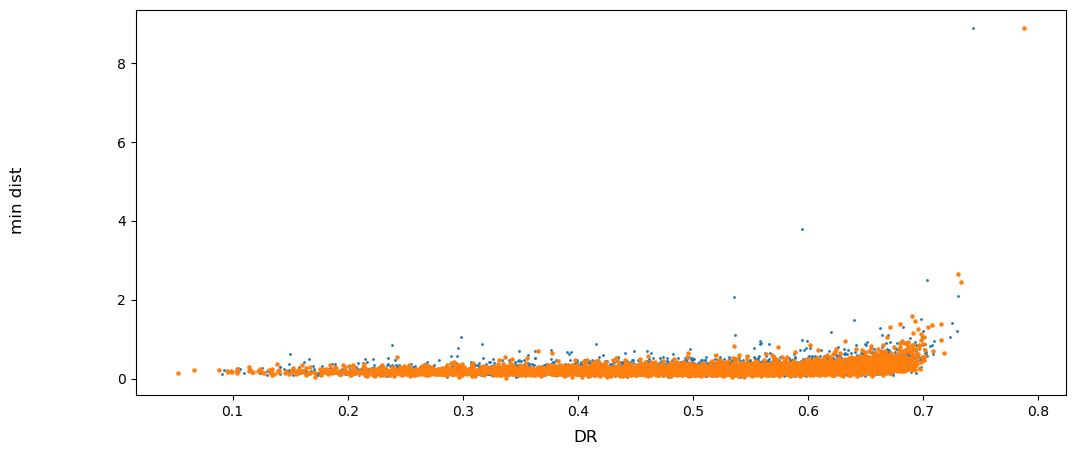

seed 82


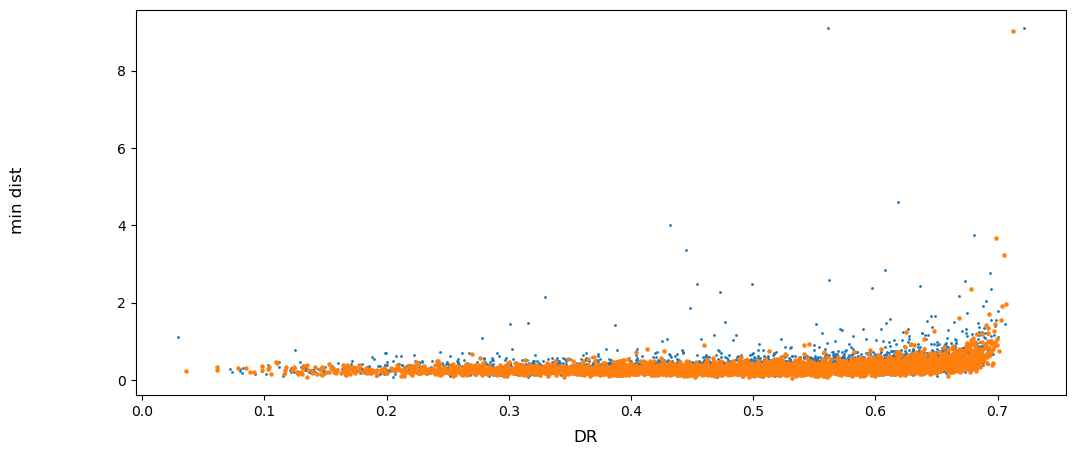

seed 92


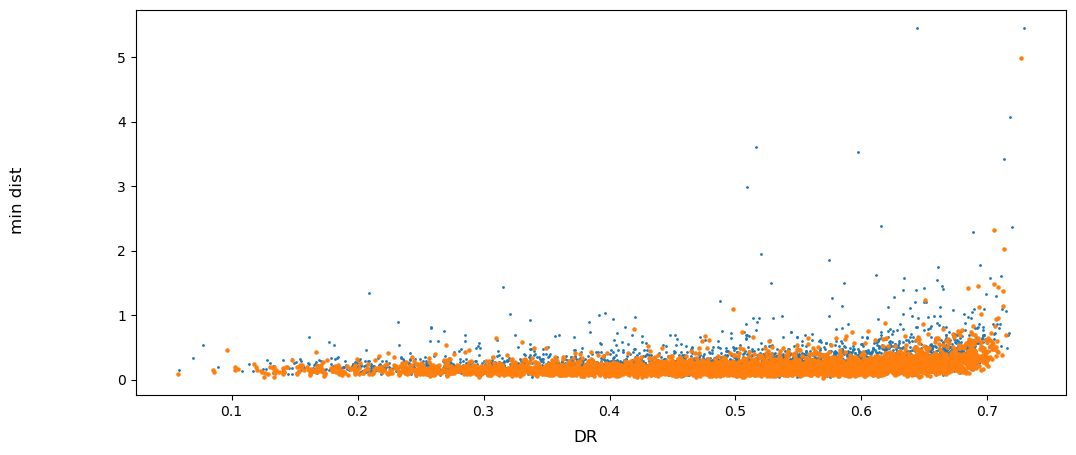

In [12]:
import cudf
from cuml.neighbors import NearestNeighbors
import multiprocessing as mp

n_workers = 4
noise_scale = 0.1
pct = 0.01

for seed in seeds:  
    print("seed", seed)

    dr_1 = dr_dict[seed][0]
    dr_2 = dr_dict[seed][noise_scale]

    n_points = 10_000
    np.random.seed(seed)
    events = events_3_dict[seed]
    X = events.att_q_repr.copy()
    idx = np.random.choice(X.shape[0], n_points, replace=False, p=events.weights / events.weights.sum())
    events_sampled = events[idx]
    X = X[idx]
    is_3b = events_sampled.is_3b
    is_bg4b = events_sampled.is_bg4b
    is_signal = events_sampled.is_signal


    n_neighbors = int(n_points * pct)
    X_cudf = cudf.DataFrame(X)
    model = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", metric="euclidean")
    nbrs = model.fit(X_cudf)
    distances, indices = nbrs.kneighbors(X_cudf)
    distances = distances.to_numpy()
    indices = indices.to_numpy()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))
    fig.supxlabel("DR")
    fig.supylabel("min dist")


    rho = fvt_scores_dict[seed][n_sample_ratio][idx]
    min_dists = np.inf * np.ones(n_points)
    rho_argsort = np.argsort(rho)[::-1]
    dist_func = lambda x, y: np.linalg.norm(x - y, axis=1)

    def min_dist_fn(i):
        if i == 0:
            return np.inf
        else:
            return np.min(dist_func(X[rho_argsort[i]], X[rho_argsort[:i]]))

    with mp.Pool(n_workers) as pool:
        min_dists = np.array(pool.map(min_dist_fn, np.arange(n_points)))

    min_dists[rho_argsort] = min_dists.copy()
    min_dists[np.isinf(min_dists)] = np.max(min_dists[~np.isinf(min_dists)]) # replace inf with max

    dr_diff = (dr_1 - dr_2)[idx]
    large_dr_diffs = dr_diff > np.quantile(dr_diff, 0.5)
    ax.scatter(rho[~large_dr_diffs], min_dists[~large_dr_diffs], s=1, label="small dr diff")
    ax.scatter(rho[large_dr_diffs], min_dists[large_dr_diffs], s=5, label="large dr diff")


    plt.show()
    plt.close()